# Power Ratings Process

## Data Prep

### pulling in data

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pytz
import warnings
import os
import textwrap
import re

warnings.filterwarnings("ignore")

# --- Timezone Setup ---
cst = pytz.timezone('America/Chicago')
formatted_date = '06_26_2022'
current_season = 2022

# --- Creating Folder Path ---
folder_path = f"./PEAR/PEAR Baseball/y{current_season}"
os.makedirs(folder_path, exist_ok=True)

# --- PEAR Win Probability ---
def PEAR_Win_Prob(home_pr, away_pr, location="Neutral"):
    if location != "Neutral":
        home_pr += 0.8
    rating_diff = home_pr - away_pr
    return round(1 / (1 + 10 ** (-rating_diff / 7.0)) * 100, 2)

# --- Helper Functions ---
def get_soup(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    response.raise_for_status()
    return BeautifulSoup(response.text, "html.parser")

def scrape_warrennolan_table(url, expected_columns):
    soup = get_soup(url)
    table = soup.find('table', class_='normal-grid alternating-rows stats-table')
    data = []
    if table:
        for row in table.find('tbody').find_all('tr'):
            cells = row.find_all('td')
            if len(cells) >= 2:
                name_div = cells[1].find('div', class_='name-subcontainer')
                full_text = name_div.text.strip() if name_div else cells[1].text.strip()
                parts = full_text.split("\n")
                team_name = parts[0].strip()
                conference = parts[1].split("(")[0].strip() if len(parts) > 1 else ""
                data.append([cells[0].text.strip(), team_name, conference])
    return pd.DataFrame(data, columns=expected_columns)

def clean_team_names(df, column='Team'):
    df[column] = df[column].str.replace('State', 'St.', regex=False)
    df[column] = df[column].replace(team_replacements)
    return df

# --- NCAA Stats Dropdown ---
base_url = "https://www.ncaa.com"
soup = get_soup(f"{base_url}/stats/baseball/d1")
dropdown = soup.find("select", {"id": "select-container-team"})
stat_links = {
    option.text.strip(): base_url + option["value"]
    for option in dropdown.find_all("option") if option.get("value")
}

# --- NCAA RPI Table ---
rpi_url = "https://www.ncaa.com/rankings/baseball/d1/rpi"
rpi_soup = get_soup(rpi_url)
table = rpi_soup.find("table", class_="sticky")

if table:
    headers = [th.text.strip() for th in table.find_all("th")]
    data = [
        [td.text.strip() for td in row.find_all("td")]
        for row in table.find_all("tr")[1:]
    ]
    rpi = pd.DataFrame(data, columns=headers).drop(columns=["Previous"])
    rpi.rename(columns={"School": "Team"}, inplace=True)
else:
    print("NCAA RPI Table not found.")
    rpi = pd.DataFrame()

# --- Projected RPI ---
projected_rpi = scrape_warrennolan_table(
    'https://www.warrennolan.com/baseball/2022/rpi-predict',
    expected_columns=["RPI", "Team", "Conference"]
)

# --- Live RPI ---
live_rpi = scrape_warrennolan_table(
    'https://www.warrennolan.com/baseball/2022/rpi-live',
    expected_columns=["Live_RPI", "Team", "Conference"]
)

# --- ELO Ratings ---
url = 'https://www.warrennolan.com/baseball/2022/elo'

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table with the specified class
table = soup.find('table', class_='normal-grid alternating-rows stats-table')

if table:
    # Extract table headers
    headers = [th.text.strip() for th in table.find('thead').find_all('th')]
    headers.insert(1, "Team Link")  # Adding extra column for team link

    # Extract table rows
    data = []
    for row in table.find('tbody').find_all('tr'):
        cells = row.find_all('td')
        row_data = []
        for i, cell in enumerate(cells):
            # If it's the first cell, extract team name and link from 'name-subcontainer'
            if i == 0:
                name_container = cell.find('div', class_='name-subcontainer')
                if name_container:
                    team_name = name_container.text.strip()
                    team_link_tag = name_container.find('a')
                    team_link = team_link_tag['href'] if team_link_tag else ''
                else:
                    team_name = cell.text.strip()
                    team_link = ''
                row_data.append(team_name)
                row_data.append(team_link)  # Add team link separately
            else:
                row_data.append(cell.text.strip())
        data.append(row_data)


    elo_data = pd.DataFrame(data, columns=[headers])
    elo_data.columns = elo_data.columns.get_level_values(0)
    elo_data = elo_data.drop_duplicates(subset='Team', keep='first')
    elo_data = elo_data.astype({col: 'str' for col in elo_data.columns if col not in ['ELO', 'Rank']})
    elo_data['ELO'] = elo_data['ELO'].astype(float, errors='ignore')
    elo_data['Rank'] = elo_data['Rank'].astype(int, errors='ignore')
    elo_data.rename(columns={'Rank': 'ELO_Rank'}, inplace=True)

else:
    print("Table not found on the page.")

# --- Team Name Replacements ---
team_replacements = {
    'North Carolina St.': 'NC State',
    'Southern Miss': 'Southern Miss.',
    'USC': 'Southern California',
    'Dallas Baptist': 'DBU',
    'Charleston': 'Col. of Charleston',
    'Georgia Southern': 'Ga. Southern',
    'UNCG': 'UNC Greensboro',
    'East Tennessee St.': 'ETSU',
    'Lamar': 'Lamar University',
    "Saint Mary's College": "Saint Mary's (CA)",
    'Western Kentucky': 'Western Ky.',
    'FAU': 'Fla. Atlantic',
    'Connecticut': 'UConn',
    'Southeast Missouri': 'Southeast Mo. St.',
    'Alcorn St.': 'Alcorn',
    'Appalachian St.': 'App State',
    'Arkansas-Pine Bluff': 'Ark.-Pine Bluff',
    'Army': 'Army West Point',
    'Cal St. Bakersfield': 'CSU Bakersfield',
    'Cal St. Northridge': 'CSUN',
    'Central Arkansas': 'Central Ark.',
    'Central Michigan': 'Central Mich.',
    'Charleston Southern': 'Charleston So.',
    'Eastern Illinois': 'Eastern Ill.',
    'Eastern Kentucky': 'Eastern Ky.',
    'Eastern Michigan': 'Eastern Mich.',
    'Fairleigh Dickinson': 'FDU',
    'Grambling St.': 'Grambling',
    'Incarnate Word': 'UIW',
    'Long Island': 'LIU',
    'Maryland Eastern Shore': 'UMES',
    'Middle Tennessee': 'Middle Tenn.',
    'Mississippi Valley St.': 'Mississippi Val.',
    "Mount Saint Mary's": "Mount St. Mary's",
    'North Alabama': 'North Ala.',
    'North Carolina A&T': 'N.C. A&T',
    'Northern Colorado': 'Northern Colo.',
    'Northern Kentucky': 'Northern Ky.',
    'Prairie View A&M': 'Prairie View',
    'Presbyterian College': 'Presbyterian',
    'Saint Bonaventure': 'St. Bonaventure',
    "Saint John's": "St. John's (NY)",
    'Sam Houston St.': 'Sam Houston',
    'Seattle University': 'Seattle U',
    'South Carolina Upstate': 'USC Upstate',
    'South Florida': 'South Fla.',
    'Southeastern Louisiana': 'Southeastern La.',
    'Southern': 'Southern U.',
    'Southern Illinois': 'Southern Ill.',
    'Stephen F. Austin': 'SFA',
    'Tennessee-Martin': 'UT Martin',
    'Texas A&M-Corpus Christi': 'A&M-Corpus Christi',
    'UMass-Lowell': 'UMass Lowell',
    'UTA': 'UT Arlington',
    'Western Carolina': 'Western Caro.',
    'Western Illinois': 'Western Ill.',
    'Western Michigan': 'Western Mich.',
    'Albany': 'UAlbany',
    'Southern Indiana': 'Southern Ind.',
    'Queens': 'Queens (NC)',
    'Central Connecticut': 'Central Conn. St.',
    'Saint Thomas': 'St. Thomas (MN)',
    'Northern Illinois': 'NIU',
    'UMass': 'Massachusetts',
    'Loyola-Marymount': 'LMU (CA)'
}

# Apply team name cleanup
elo_data = clean_team_names(elo_data)
projected_rpi = clean_team_names(projected_rpi)
live_rpi = clean_team_names(live_rpi)

In [26]:
year_before = scrape_warrennolan_table(
    'https://www.warrennolan.com/baseball/2021/rpi-live',
    expected_columns=["Live_RPI", "Team", "Conference"]
)
year_before = clean_team_names(year_before)
year_before.rename(columns={"Live_RPI": "Rank"}, inplace=True)

In [24]:
ba = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/batting_average.csv")
ba['HPG'] = ba['H'] / ba['G']
ba['ABPG'] = ba['AB'] / ba['G']
ba['HPAB'] = ba['H'] / ba['AB']
ba = ba.drop(columns=['Rank', 'W-L'])

bb = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/base_on_balls.csv")
bb['BBPG'] = bb['BB'] / bb['G']
bb = bb.drop(columns=['Rank', 'G', 'W-L'])

era = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/earned_run_average.csv")
era['RA'] = era['R']
era = era.drop(columns=['Rank', 'G', 'W-L', 'R'])

fp = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/fielding_percentage.csv")
fp['APG'] = fp['A'] / fp['G']
fp['EPG'] = fp['E'] / fp['G']
fp = fp.drop(columns=['Rank', 'G', 'W-L'])

obp = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/on_base_percentage.csv")
obp['OBP'] = obp['PCT']
obp['HBPPG'] = obp['HBP'] / obp['G']
obp = obp.drop(columns=['Rank', 'G', 'W-L', 'H', 'AB', 'BB', 'SF', 'SH', 'PCT'])

runs = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/runs.csv")
runs['RPG'] = runs['R'] / runs['G']
runs['RS'] = runs['R']
runs = runs.drop(columns=['Rank', 'G', 'W-L', 'R'])

slg = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/slugging_percentage.csv")
slg['SLG'] = slg['SLG PCT']
slg = slg.drop(columns=['Rank', 'G', 'W-L', 'SLG PCT', 'AB'])

sp9 = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/strikeout_per_nine.csv")
sp9['KP9'] = sp9['K/9']
sp9 = sp9.drop(columns=['Rank', 'G', 'W-L', 'K/9', 'IP', 'SO'])

wp9 = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/walk_per_nine.csv")
wp9['WP9'] = wp9['PG']
wp9 = wp9.drop(columns=['Rank', 'G', 'W-L', 'BB', 'IP', 'PG'])

whip = pd.read_csv("./PEAR/PEAR Baseball/y2022/Data/whip.csv")
whip = whip.drop(columns=['Rank', 'W-L', 'BB', 'HA', 'IP'])

dfs = [ba, bb, era, fp, obp, runs, slg, sp9, wp9, whip]
baseball_stats = dfs[0]
for df in dfs[1:]:
    baseball_stats = pd.merge(baseball_stats, df, on='Name', how='left')
baseball_stats.rename(columns={'Name': 'Team'}, inplace=True)
baseball_stats["OPS"] = baseball_stats["SLG"] + baseball_stats["OBP"]
baseball_stats["PYTHAG"] = round(
    (baseball_stats["RS"] ** 1.83) / ((baseball_stats["RS"] ** 1.83) + (baseball_stats["RA"] ** 1.83)), 3
)
baseball_stats = pd.merge(baseball_stats, elo_data, on='Team', how='left')

In [25]:
missing_teams = set(elo_data['Team']) - set(baseball_stats['Team'])
elo_data_sorted = elo_data.sort_values(by='ELO_Rank')
elo_data_sorted['Percentile'] = 100 - (elo_data_sorted['ELO_Rank'].rank() - 1) / (elo_data_sorted.shape[0] - 1) * 100
matched_percentiles = elo_data_sorted[elo_data_sorted['Team'].isin(missing_teams)][['Team', 'Percentile']]
percentile_dict = dict(zip(matched_percentiles['Team'], matched_percentiles['Percentile']))

### creating wOBA, FIP, WAR

In [26]:
hbp = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/hit_by_pitch.csv")[['Name', 'G', 'HBP']]
hits = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/hits.csv")[['Name', 'AB', 'H']]
doubles = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/doubles.csv")[['Name', '2B']]
triples = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/triples.csv")[['Name', '3B']]
home_runs = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/home_runs_per_game.csv")
home_runs.rename(columns={'PG': 'HRPG'}, inplace=True)
home_runs = home_runs.drop(columns=['Rank', 'G', 'W-L'])
sf = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/sacrifice_flies.csv")[['Name', 'SF']]
sb = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/sacrifice_bunts.csv")
sb.rename(columns={'SH': 'SB'}, inplace=True)
sb['SBPG'] = sb['SB'] / sb['G']
sb = sb.drop(columns=['Rank', 'G', 'W-L'])
stw = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/stw_ratio.csv")
stw.rename(columns={'BB':'PBB'}, inplace=True)
stw = stw[['Name', 'K/BB', 'PBB', 'SO']]
ha = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/hits_allowed.csv")
ha.rename(columns={'PG': 'HAPG'}, inplace=True)
ha = ha[['Name', 'HA', 'HAPG']]
hit_batters = pd.read_csv("./PEAR/PEAR Baseball/y2023/Data/hit_batters.csv")[['Name', 'HB']]

dfs = [bb, hbp, hits, doubles, triples, home_runs, sf, runs, sb, era, stw, ha, hit_batters]
wOBA = dfs[0]
for df in dfs[1:]:
    wOBA = pd.merge(wOBA, df, on='Name', how='left')
wOBA.rename(columns={'Name': 'Team'}, inplace=True)
wOBA = wOBA.fillna(0)
wOBA["PA"] = wOBA["AB"] + wOBA["BB"] + wOBA["HBP"] + wOBA["SF"] + wOBA["SB"]
league_HR_per_game = wOBA["HR"].sum() / wOBA["G"].sum()
wOBA["HR_A"] = wOBA["G"] * league_HR_per_game

In [27]:
wOBA['1B'] = wOBA['H'] - wOBA['2B'] - wOBA['3B'] - wOBA['HR']
wOBA['wOBA'] = ((0.69 * wOBA['BB']) + (0.72 * wOBA['HBP']) + (0.88 * wOBA['1B']) + (1.24 * wOBA['2B']) + (1.56 * wOBA['3B']) + (1.95 * wOBA['HR'])) / (wOBA['PA'])
league_wOBA = (wOBA['wOBA'] * wOBA['PA']).sum() / wOBA['PA'].sum()
league_R_PA = wOBA['RS'].sum() / wOBA['PA'].sum()
wOBA_scale = league_R_PA / league_wOBA
wOBA['wRAA'] = ((wOBA['wOBA'] - league_wOBA) / wOBA_scale) * wOBA['PA']
league_RS = wOBA['RS'].sum()
league_G = wOBA['G'].sum()
RPW = 2 * (league_RS / league_G)
wOBA['oWAR'] = wOBA['wRAA'] / RPW
wOBA['ISO'] = (wOBA['2B'] + (2 * wOBA['3B']) + (3 * wOBA['HR'])) / wOBA['AB']
wOBA['wRC'] = (((wOBA['wOBA'] - league_wOBA) / wOBA_scale) + league_R_PA) * wOBA['PA']
wOBA['wRC+'] = (wOBA['wRC'] / wOBA['PA']) / league_R_PA * 100
wOBA['BB%'] = wOBA['BB'] / wOBA['PA']
wOBA['BABIP'] = (wOBA['H'] - wOBA['HR']) / (wOBA['AB'] + wOBA['SF'])

In [28]:
wOBA['RA9'] = (wOBA['RA'] / wOBA['IP']) * 9
wOBA['LOB%'] = (wOBA['HA'] + wOBA['PBB'] + wOBA['HB'] - wOBA['RA']) / (wOBA['HA'] + wOBA['PBB'] + wOBA['HB'] - (1.4*wOBA['HR_A']))
wOBA['FIP'] = ((13 * wOBA['HR_A'] + 3 * (wOBA['PBB'] + wOBA['HB']) - 2 * wOBA['SO']) / wOBA['IP'])

league_RA9 = wOBA['RA'].sum() / wOBA['G'].sum()
league_ERA = (wOBA['ER'].sum() * 9) / wOBA['IP'].sum()
replacement_level_ERA = wOBA['ERA'].quantile(0.80)
multiplier = replacement_level_ERA / league_ERA
replacement_RA9 = league_RA9 * multiplier
league_FIP = (wOBA['FIP'] * wOBA['IP']).sum() / wOBA['IP'].sum()
replacement_level_FIP = wOBA['FIP'].quantile(0.80)
multiplier = replacement_level_FIP / league_FIP
replacement_RA9 = league_RA9 * multiplier  # Adjust RA9 to match replacement level
wOBA['pWAR'] = ((replacement_RA9 - wOBA['FIP']) / RPW) * (wOBA['IP'] / 9)

mean_oWAR = wOBA['oWAR'].mean()
std_oWAR = wOBA['oWAR'].std()
mean_pWAR = wOBA['pWAR'].mean()
std_pWAR = wOBA['pWAR'].std()
wOBA['oWAR_z'] = (wOBA['oWAR'] - mean_oWAR) / std_oWAR
wOBA['pWAR_z'] = (wOBA['pWAR'] - mean_pWAR) / std_pWAR
wOBA['fWAR'] = wOBA['oWAR_z'] + wOBA['pWAR_z']

In [29]:
baseball_stats = pd.merge(baseball_stats, wOBA[['Team', 'wOBA', 'wRAA', 'oWAR_z', 'pWAR_z', 'fWAR', 'ISO', 'wRC+', 'BB%', 'BABIP', 'RA9', 'FIP', 'LOB%', 'K/BB']], how='left', on='Team')

## PEAR Modeling

In [30]:
rpi_2024 = pd.read_csv("./PEAR/PEAR Baseball/y2021/rpi_end_2021.csv")
rpi_2024['Rank'] = rpi_2024['Rank'].astype(int, errors='ignore')

modeling_stats = baseball_stats[['Team', 'HPG',
                'BBPG', 'ERA', 'PCT', 
                'KP9', 'WP9', 'OPS', 'BB%',
                'WHIP', 'PYTHAG', 'fWAR', 'oWAR_z', 'pWAR_z', 'K/BB', 'wRC+', 'LOB%', 'wOBA', 'ELO_Rank']]
modeling_stats = pd.merge(modeling_stats, rpi_2024[['Team', 'Rank']], on = 'Team', how='left')
modeling_stats["Rank"] = modeling_stats["Rank"].apply(pd.to_numeric, errors='coerce')
modeling_stats["ELO_Rank"] = modeling_stats["ELO_Rank"].apply(pd.to_numeric, errors='coerce')
modeling_stats['Rank_pct'] = 1 - (modeling_stats['Rank'] - 1) / (len(modeling_stats) - 1)

higher_better = ["HPG", "BBPG", "BB%", "PCT", "KP9", "OPS", "Rank_pct", 'PYTHAG', 'fWAR', 'oWAR_z', 'pWAR_z', 'K/BB', 'wRC+', 'LOB%', 'wOBA']
lower_better = ["ERA", "WP9", "WHIP"]

scaler = MinMaxScaler(feature_range=(1, 100))
modeling_stats[higher_better] = scaler.fit_transform(modeling_stats[higher_better])
modeling_stats[lower_better] = scaler.fit_transform(-modeling_stats[lower_better])
modeling_stats.dropna(inplace=True)

In [31]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.stats import spearmanr

# Available features
features_all = ["BB%", "PCT", "OPS", 'PYTHAG', 'fWAR', 'K/BB', 'wRC+', 'LOB%', "ERA", "WHIP", "wOBA", "Rank_pct"]

# Target variable
target = modeling_stats['ELO_Rank'].values

# --- SPEARMAN OBJECTIVE FUNCTION ---
def spearman_objective(weights_raw):
    # First half: binary values for feature selection (0 or 1)
    feature_selection = np.array(weights_raw[:len(features_all)])
    # Second half: continuous values for weights
    weights = np.array(weights_raw[len(features_all):])
    
    # Ensure the weights sum to 1 for the selected features
    selected_features = [features_all[i] for i in range(len(features_all)) if feature_selection[i] > 0.5]
    
    if len(selected_features) == 0:
        return 1  # Return high value (bad result) if no features are selected
    
    weights /= np.sum(weights)  # Normalize weights to sum to 1
    
    # Compute weighted sum of the selected features
    combined = sum(w * modeling_stats[feat] for w, feat in zip(weights, selected_features))
    ranks = combined.rank(ascending=False)
    
    # Calculate Spearman correlation
    corr, _ = spearmanr(ranks, target)
    return -corr  # Negative because we are minimizing

# --- RUNNING DIFFERENTIAL EVOLUTION ---
def run_differential_evolution():
    bounds = [(0, 1)] * len(features_all) + [(0, 1)] * len(features_all)  # binary for selection + continuous for weights
    result = differential_evolution(
        spearman_objective, 
        bounds=bounds, 
        strategy='best1bin', 
        maxiter=1000, 
        polish=True,
        seed=42
    )
    
    # Extract the binary selections and weights
    feature_selection = np.array(result.x[:len(features_all)]) > 0.5
    weights = np.array(result.x[len(features_all):])
    weights /= np.sum(weights)  # Normalize weights
    
    selected_features = [features_all[i] for i in range(len(features_all)) if feature_selection[i]]
    return selected_features, weights, -result.fun

# --- GETTING BEST FEATURES, WEIGHTS AND SPEARMAN ---
selected_features, best_weights, best_spearman = run_differential_evolution()

# --- OUTPUT ---
feature_weights_dict = dict(zip(selected_features, best_weights))
sorted_features_weights = sorted(feature_weights_dict.items(), key=lambda item: item[1], reverse=True)
print("Selected Features:")
for feature, weight in sorted_features_weights:
    print(f"{feature}: {weight}")

Selected Features:
Rank_pct: 0.18078092905232604
WHIP: 0.07106771504203663
fWAR: 0.04890548622929111
K/BB: 0.01870762924226382
PCT: 0.013007972386683516


In [32]:
modeling_stats['in_house_pr'] = sum(
    modeling_stats[feat] * weight for feat, weight in zip(selected_features, best_weights)
)
modeling_stats['Rating'] = modeling_stats['in_house_pr'] - modeling_stats['in_house_pr'].mean()
current_range = modeling_stats['Rating'].max() - modeling_stats['Rating'].min()
desired_range = 15
scaling_factor = desired_range / current_range
modeling_stats['Rating'] = round(modeling_stats['Rating'] * scaling_factor, 4)
modeling_stats['Rating'] = modeling_stats['Rating'] - modeling_stats['Rating'].min()
modeling_stats['Rating'] = round(modeling_stats['Rating'] - modeling_stats['Rating'].mean(),2)
modeling_stats['Rating'] = round(modeling_stats['Rating'], 2)

In [33]:
ending_data = pd.merge(baseball_stats, modeling_stats[['Team', 'Rating']], on="Team", how="inner").sort_values('Rating', ascending=False).reset_index(drop=True)
ending_data.index = ending_data.index + 1

In [34]:
ending_data.dropna(inplace=True)

## Schedule Info Load

### Data Pull

In [35]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
url = 'https://www.warrennolan.com/baseball/2022/elo'

# Fetch the webpage content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the table with the specified class
table = soup.find('table', class_='normal-grid alternating-rows stats-table')

if table:
    # Extract table headers
    headers = [th.text.strip() for th in table.find('thead').find_all('th')]
    headers.insert(1, "Team Link")  # Adding extra column for team link

    # Extract table rows
    data = []
    for row in table.find('tbody').find_all('tr'):
        cells = row.find_all('td')
        row_data = []
        for i, cell in enumerate(cells):
            # If it's the first cell, extract team name and link from 'name-subcontainer'
            if i == 0:
                name_container = cell.find('div', class_='name-subcontainer')
                if name_container:
                    team_name = name_container.text.strip()
                    team_link_tag = name_container.find('a')
                    team_link = team_link_tag['href'] if team_link_tag else ''
                else:
                    team_name = cell.text.strip()
                    team_link = ''
                row_data.append(team_name)
                row_data.append(team_link)  # Add team link separately
            else:
                row_data.append(cell.text.strip())
        data.append(row_data)


    elo_data = pd.DataFrame(data, columns=[headers])
    elo_data.columns = elo_data.columns.get_level_values(0)
    elo_data = elo_data.drop_duplicates(subset='Team', keep='first')
    elo_data = elo_data.astype({col: 'str' for col in elo_data.columns if col not in ['ELO', 'Rank']})
    elo_data['ELO'] = elo_data['ELO'].astype(float, errors='ignore')
    elo_data['Rank'] = elo_data['Rank'].astype(int, errors='ignore')

else:
    print("Table not found on the page.")

In [36]:
file_paths = [
    "PEAR/PEAR Baseball/y2021/schedule_2021.csv",
    "PEAR/PEAR Baseball/y2022/schedule_2022.csv"
]
dataframes = []
for path in file_paths:
    df = pd.read_csv(path)
    year = int(path.split("schedule_")[1].split(".csv")[0])
    df["year"] = year
    dataframes.append(df)
games = pd.concat(dataframes, ignore_index=True)[['Team', 'Date', 'home_team', 'away_team', 'home_score', 'away_score', 'Result', 'Location']]
games = games[games["home_score"] != games["away_score"]].copy()
games = games[games['Location'] != 'Neutral'].copy()
games["total_runs"] = games["home_score"] + games["away_score"]
home_runs = games.groupby("home_team")["total_runs"].mean().rename("home_runs_per_game")
away_games = games[["home_team", "away_team", "home_score", "away_score", "total_runs"]].copy()
away_games = away_games.rename(columns={"home_team": "opponent", "away_team": "team"})
away_runs = away_games.groupby("team")["total_runs"].mean().rename("away_runs_per_game")
park_factors = pd.concat([home_runs, away_runs], axis=1)
park_factors["park_factor"] = park_factors["home_runs_per_game"] / park_factors["away_runs_per_game"]
park_factors = park_factors.sort_values("park_factor", ascending=False)
park_factors = park_factors.reset_index(names='Team')
park_factors = park_factors[~park_factors['Team'].str.contains('Non Div', na=False)].reset_index(drop=True)
pf_lookup = dict(zip(park_factors['Team'], park_factors['park_factor']))

In [37]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Define constants
BASE_URL = "https://www.warrennolan.com"

# Setup a persistent session for reuse across requests
session = requests.Session()
session.headers.update({"User-Agent": "Mozilla/5.0"})

def get_park_factor(row):
    if row['Location'] == 'Neutral':
        return 1
    return pf_lookup.get(row['home_team'], 1)

# Function to extract schedule data for a single team
def extract_schedule_data(team_name, team_url, session):
    schedule_url = BASE_URL + team_url
    team_schedule = []

    try:
        response = session.get(schedule_url, timeout=10)
        response.raise_for_status()
    except Exception as e:
        print(f"[Error] {team_name} → {e}")
        return []

    soup = BeautifulSoup(response.text, 'html.parser')
    schedule_lists = soup.find_all("ul", class_="team-schedule")
    if not schedule_lists:
        return []

    schedule_list = schedule_lists[0]

    for game in schedule_list.find_all('li', class_='team-schedule'):
        try:
            # Date
            month = game.find('span', class_='team-schedule__game-date--month')
            day = game.find('span', class_='team-schedule__game-date--day')
            dow = game.find('span', class_='team-schedule__game-date--dow')
            game_date = f"{month.get_text(strip=True)} {day.get_text(strip=True)} ({dow.get_text(strip=True)})"

            # Opponent
            opponent_link = game.select_one('.team-schedule__opp-line-link')
            opponent_name = opponent_link.get_text(strip=True) if opponent_link else ""

            # Location
            location_div = game.find('div', class_='team-schedule__location')
            location_text = location_div.get_text(strip=True) if location_div else ""
            if "VS" in location_text:
                game_location = "Neutral"
            elif "AT" in location_text:
                game_location = "Away"
            else:
                game_location = "Home"

            # Result
            result_info = game.find('div', class_='team-schedule__result')
            result_text = result_info.get_text(strip=True) if result_info else "N/A"

            # Box score
            box_score_table = game.find('table', class_='team-schedule-bottom__box-score')
            home_team = away_team = home_score = away_score = "N/A"

            if box_score_table:
                rows = box_score_table.find_all('tr')
                if len(rows) > 2:
                    away_row = rows[1].find_all('td')
                    home_row = rows[2].find_all('td')
                    away_team = away_row[0].get_text(strip=True)
                    home_team = home_row[0].get_text(strip=True)
                    away_score = away_row[-3].get_text(strip=True)
                    home_score = home_row[-3].get_text(strip=True)

            team_schedule.append([
                team_name, game_date, opponent_name, game_location,
                result_text, home_team, away_team, home_score, away_score
            ])
        except Exception as e:
            print(f"[Parse Error] {team_name} game row → {e}")
            continue

    return team_schedule

# ThreadPool wrapper function
def fetch_all_schedules(elo_df, session, max_workers=12):
    schedule_data = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(extract_schedule_data, row["Team"], row["Team Link"], session): row["Team"]
            for _, row in elo_df.iterrows()
        }

        for future in tqdm(as_completed(futures), total=len(futures), desc="Fetching Schedules"):
            try:
                data = future.result()
                schedule_data.extend(data)
            except Exception as e:
                print(f"[Thread Error] {e}")

    return schedule_data

schedule_data = fetch_all_schedules(elo_data, session, max_workers=12)

# Create DataFrame
columns = ["Team", "Date", "Opponent", "Location", "Result", "home_team", "away_team", "home_score", "away_score"]
schedule_df = pd.DataFrame(schedule_data, columns=columns)
schedule_df = schedule_df.astype({col: 'str' for col in schedule_df.columns if col not in ['home_score', 'away_score']})
schedule_df['home_score'] = schedule_df['home_score'].astype(int, errors='ignore')
schedule_df['away_score'] = schedule_df['away_score'].astype(int, errors='ignore')
schedule_df = schedule_df.merge(elo_data[['Team', 'ELO']], left_on='home_team', right_on='Team', how='left')
schedule_df.rename(columns={'ELO': 'home_elo'}, inplace=True)
schedule_df = schedule_df.merge(elo_data[['Team', 'ELO']], left_on='away_team', right_on='Team', how='left')
schedule_df.rename(columns={'ELO': 'away_elo'}, inplace=True)
schedule_df.drop(columns=['Team', 'Team_y'], inplace=True)
schedule_df.rename(columns={'Team_x':'Team'}, inplace=True)
schedule_df['park_factor'] = schedule_df.apply(get_park_factor, axis=1)

Fetching Schedules: 100%|██████████| 301/301 [02:17<00:00,  2.20it/s]


In [38]:
schedule_df.dropna(inplace=True)

### Data Formatting

In [39]:
# Define mapping for team name replacements
team_replacements = {
    'North Carolina St.': 'NC State',
    'Southern Miss': 'Southern Miss.',
    'USC': 'Southern California',
    'Dallas Baptist': 'DBU',
    'Charleston': 'Col. of Charleston',
    'Georgia Southern': 'Ga. Southern',
    'UNCG': 'UNC Greensboro',
    'East Tennessee St.': 'ETSU',
    'Lamar': 'Lamar University',
    "Saint Mary's College": "Saint Mary's (CA)",
    'Western Kentucky': 'Western Ky.',
    'FAU': 'Fla. Atlantic',
    'Connecticut': 'UConn',
    'Southeast Missouri': 'Southeast Mo. St.',
    'Alcorn St.': 'Alcorn',
    'Appalachian St.': 'App State',
    'Arkansas-Pine Bluff': 'Ark.-Pine Bluff',
    'Army': 'Army West Point',
    'Cal St. Bakersfield': 'CSU Bakersfield',
    'Cal St. Northridge': 'CSUN',
    'Central Arkansas': 'Central Ark.',
    'Central Michigan': 'Central Mich.',
    'Charleston Southern': 'Charleston So.',
    'Eastern Illinois': 'Eastern Ill.',
    'Eastern Kentucky': 'Eastern Ky.',
    'Eastern Michigan': 'Eastern Mich.',
    'Fairleigh Dickinson': 'FDU',
    'Grambling St.': 'Grambling',
    'Incarnate Word': 'UIW',
    'Long Island': 'LIU',
    'Maryland Eastern Shore': 'UMES',
    'Middle Tennessee': 'Middle Tenn.',
    'Mississippi Valley St.': 'Mississippi Val.',
    "Mount Saint Mary's": "Mount St. Mary's",
    'North Alabama': 'North Ala.',
    'North Carolina A&T': 'N.C. A&T',
    'Northern Colorado': 'Northern Colo.',
    'Northern Kentucky': 'Northern Ky.',
    'Prairie View A&M': 'Prairie View',
    'Presbyterian College': 'Presbyterian',
    'Saint Bonaventure': 'St. Bonaventure',
    "Saint John's": "St. John's (NY)",
    'Sam Houston St.': 'Sam Houston',
    'Seattle University': 'Seattle U',
    'South Carolina Upstate': 'USC Upstate',
    'South Florida': 'South Fla.',
    'Southeastern Louisiana': 'Southeastern La.',
    'Southern': 'Southern U.',
    'Southern Illinois': 'Southern Ill.',
    'Stephen F. Austin': 'SFA',
    'Tennessee-Martin': 'UT Martin',
    'Texas A&M-Corpus Christi': 'A&M-Corpus Christi',
    'UMass-Lowell': 'UMass Lowell',
    'UTA': 'UT Arlington',
    'Western Carolina': 'Western Caro.',
    'Western Illinois': 'Western Ill.',
    'Western Michigan': 'Western Mich.',
    'Albany': 'UAlbany',
    'Southern Indiana': 'Southern Ind.',
    'Queens': 'Queens (NC)',
    'Central Connecticut': 'Central Conn. St.',
    'Saint Thomas': 'St. Thomas (MN)',
    'Northern Illinois': 'NIU',
    'UMass':'Massachusetts',
    'Loyola-Marymount':'LMU (CA)'
}

# Apply replacements and standardize 'State' to 'St.'
columns_to_replace = ['Team', 'home_team', 'away_team', 'Opponent']

for col in columns_to_replace:
    schedule_df[col] = schedule_df[col].str.replace('State', 'St.', regex=False)
    schedule_df[col] = schedule_df[col].replace(team_replacements)
elo_data['Team'] = elo_data['Team'].str.replace('State', 'St.', regex=False)
elo_data['Team'] = elo_data['Team'].replace(team_replacements)

NET Calculation Weights:
------------------------
Rating: 9.7%
RQI: 75.4%
SOS: 14.8%
NET and RPI Correlation: 99.0%
Starting Visuals
Visuals Completed


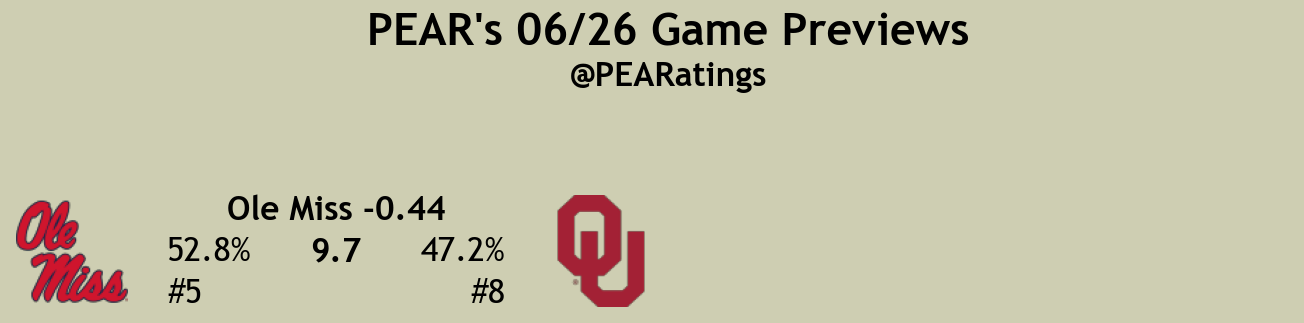

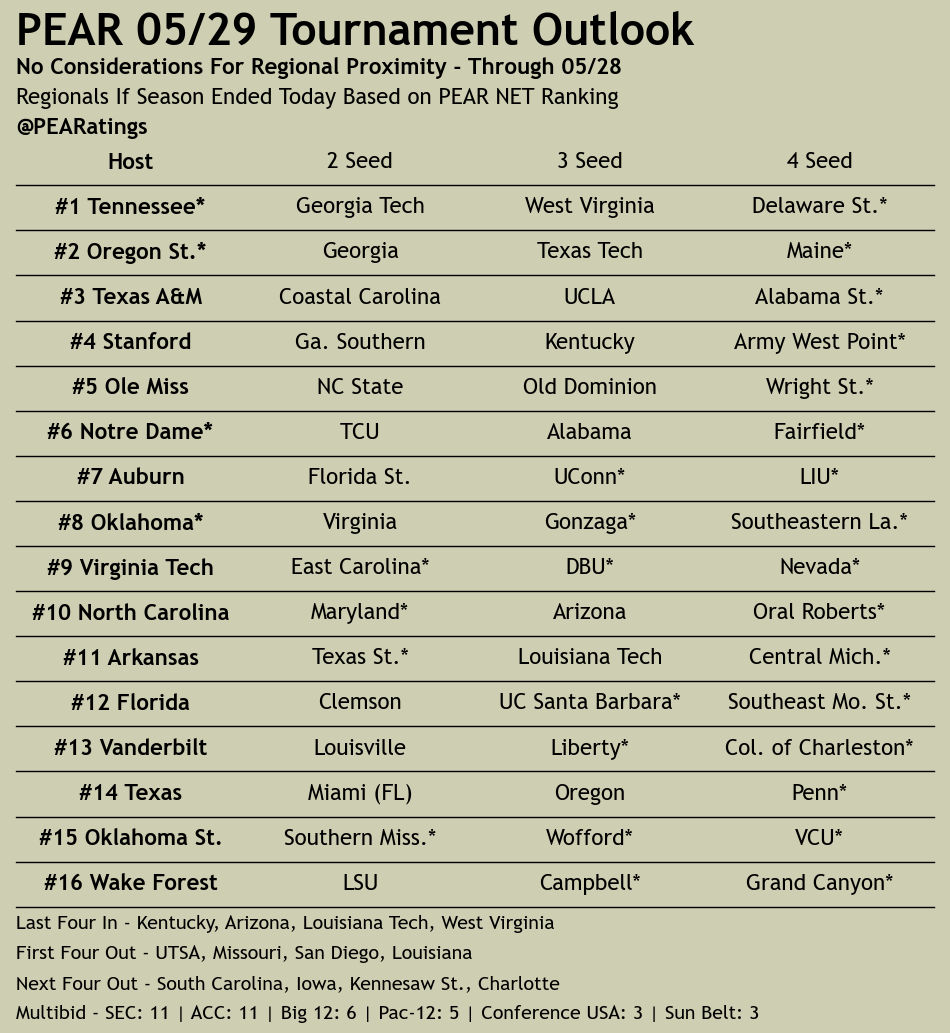

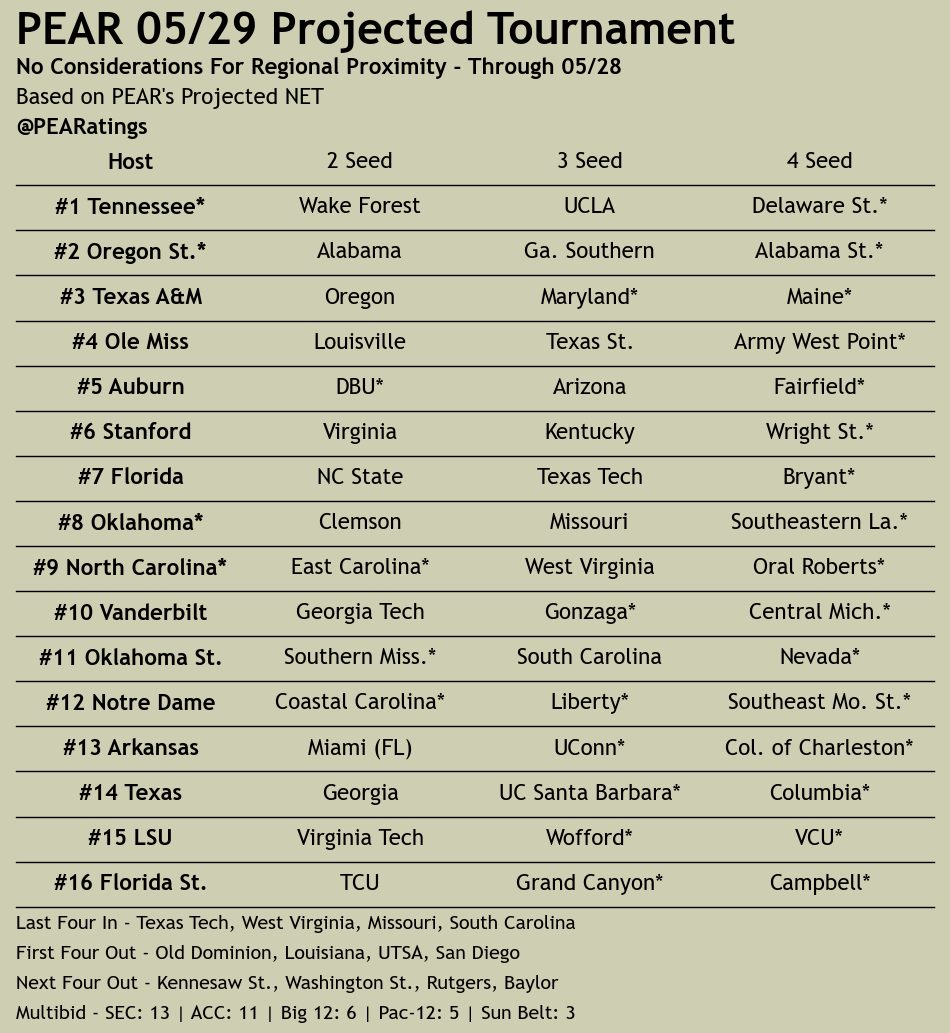

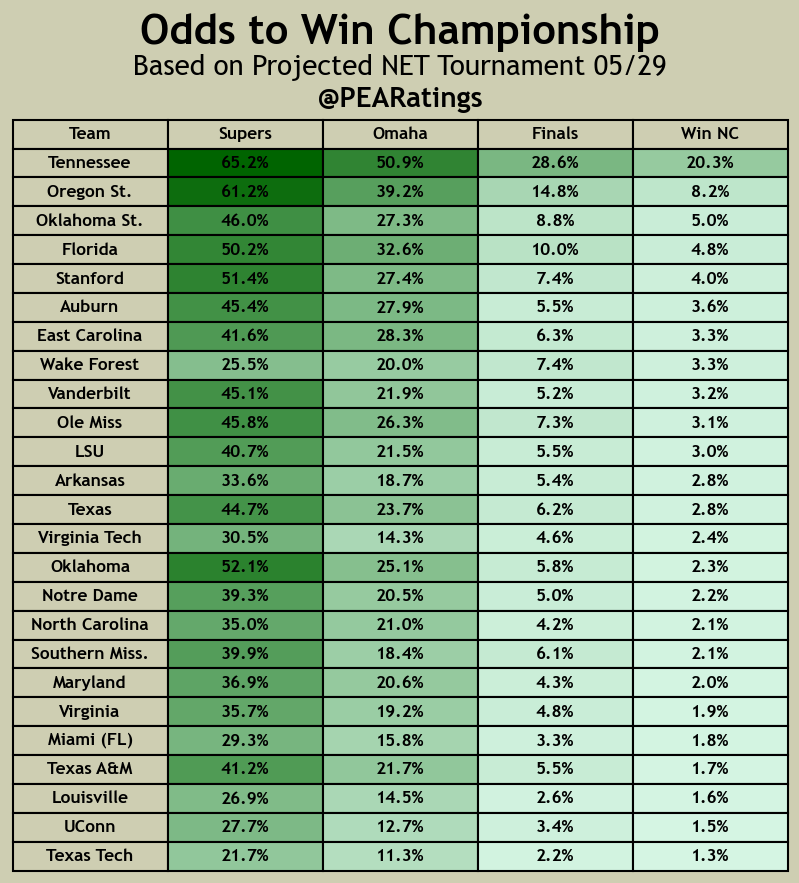

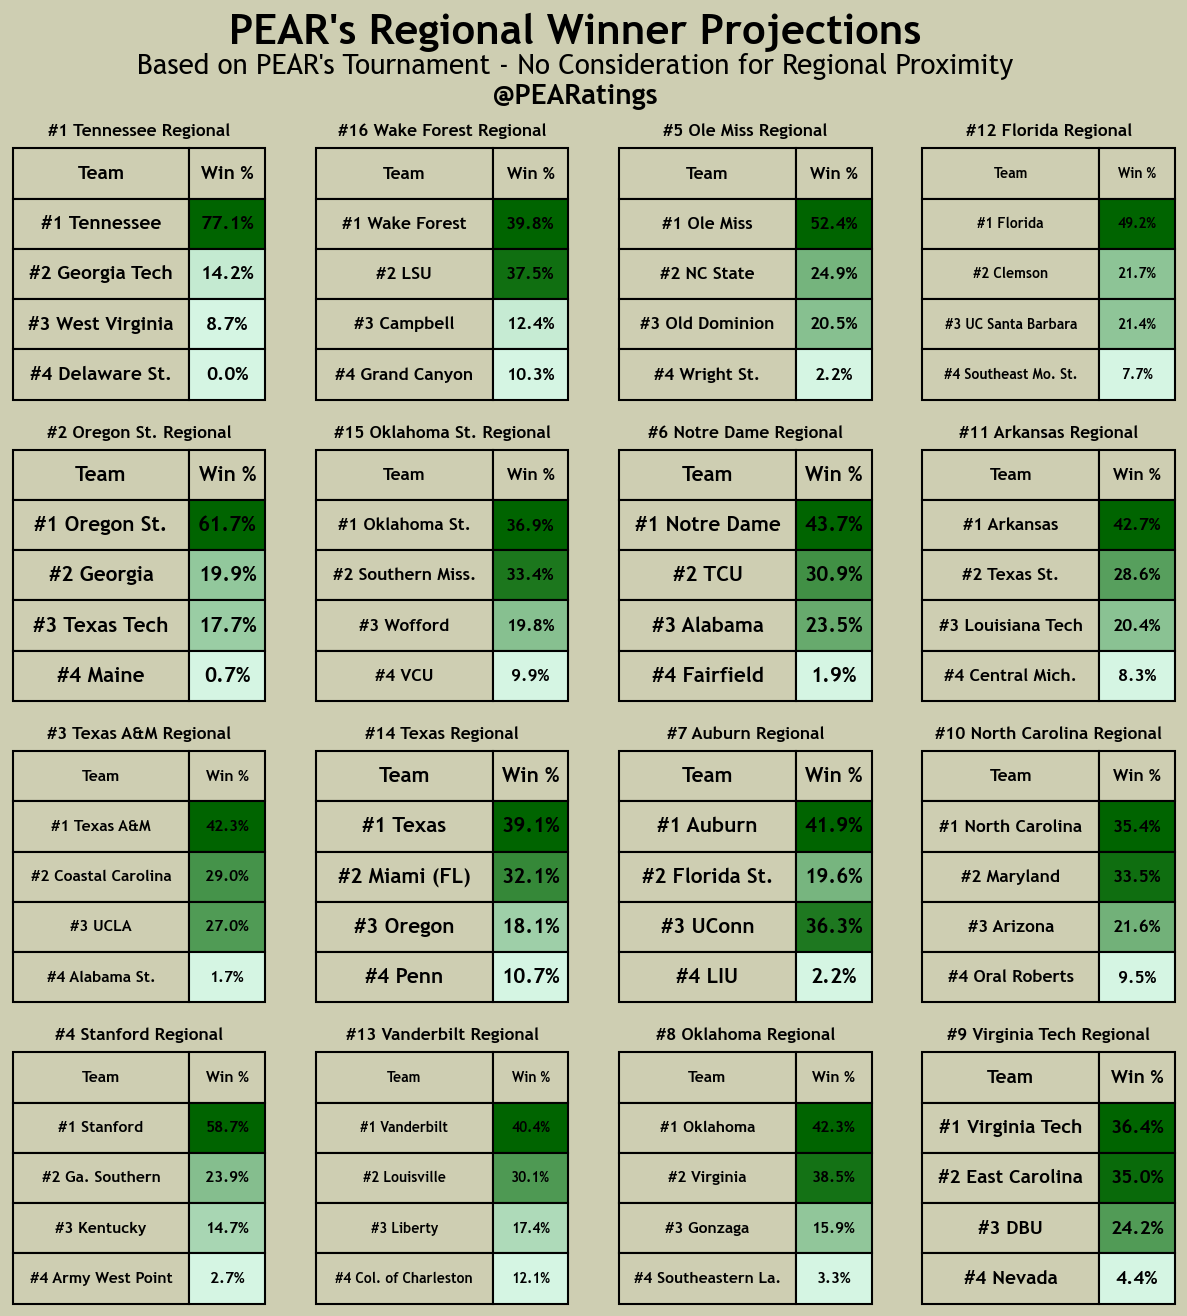

In [40]:
team_rating_quantiles = {}
for team, elo_percentile in percentile_dict.items():
    rating_at_percentile = ending_data['Rating'].quantile(elo_percentile / 100.0)
    team_rating_quantiles[team] = rating_at_percentile

# Mapping months to numerical values
month_mapping = {
    "JAN": "01", "FEB": "02", "MAR": "03", "APR": "04",
    "MAY": "05", "JUN": "06", "JUL": "07", "AUG": "08",
    "SEP": "09", "OCT": "10", "NOV": "11", "DEC": "12"
}

# Function to convert "FEB 14 (FRI)" format to "mm-dd-yyyy"
def convert_date(date_str):
    # Ensure date is a string before splitting
    if isinstance(date_str, pd.Timestamp):
        date_str = date_str.strftime("%b %d (%a)").upper()  # Convert to same format
    
    parts = date_str.split()  # ["FEB", "14", "(FRI)"]
    month = month_mapping[parts[0].upper()]  # Convert month to number
    day = parts[1]  # Extract day
    return f"{month}-{day}-{current_season}"

# Apply function to convert date format
schedule_df["Date"] = schedule_df["Date"].astype(str).apply(convert_date)
schedule_df["Date"] = pd.to_datetime(schedule_df["Date"], format="%m-%d-%Y")
comparison_date = pd.to_datetime(formatted_date, format="%m_%d_%Y")

missing_rating = round(ending_data['Rating'].mean() - 2.5*ending_data['Rating'].std(),2)
schedule_df = schedule_df.merge(ending_data[['Team', 'Rating']], left_on='home_team', right_on='Team', how='left')
schedule_df.rename(columns={'Rating': 'home_rating'}, inplace=True)
schedule_df = schedule_df.merge(ending_data[['Team', 'Rating']], left_on='away_team', right_on='Team', how='left')
schedule_df.rename(columns={'Rating': 'away_rating'}, inplace=True)
schedule_df.drop(columns=['Team', 'Team_y'], inplace=True)
schedule_df.rename(columns={'Team_x':'Team'}, inplace=True)
schedule_df['home_rating'].fillna(schedule_df['home_team'].map(team_rating_quantiles), inplace=True)
schedule_df['away_rating'].fillna(schedule_df['away_team'].map(team_rating_quantiles), inplace=True)
schedule_df['home_rating'].fillna(missing_rating, inplace=True)
schedule_df['away_rating'].fillna(missing_rating, inplace=True)
schedule_df['home_win_prob'] = schedule_df.apply(
    lambda row: PEAR_Win_Prob(row['home_rating'], row['away_rating']) / 100, axis=1
)
remaining_games = schedule_df[schedule_df["Date"] > comparison_date].reset_index(drop=True)

def adjust_home_pr(home_win_prob):
    return ((home_win_prob - 50) / 50) * 0.9

def calculate_spread_from_stats(home_pr, away_pr, home_elo, away_elo, location):
    if location != "Neutral":
        home_pr += 0.3
    elo_win_prob = round((10**((home_elo - away_elo) / 400)) / ((10**((home_elo - away_elo) / 400)) + 1) * 100, 2)
    spread = round(adjust_home_pr(elo_win_prob) + home_pr - away_pr, 2)
    return spread, elo_win_prob

schedule_df['Spread'] = schedule_df.apply(
    lambda row: calculate_spread_from_stats(
        row['home_rating'], row['away_rating'],
        row['home_elo'], row['away_elo'],
        row['Location']
    )[0],  # Only take the spread
    axis=1
)
schedule_df['elo_win_prob'] = schedule_df.apply(
    lambda row: calculate_spread_from_stats(
        row['home_rating'], row['away_rating'],
        row['home_elo'], row['away_elo'],
        row['Location']
    )[1],  # Only take the win prob
    axis=1
)
schedule_df['PEAR'] = schedule_df.apply(
    lambda row: f"{row['away_team']} {-abs(row['Spread'])}" if ((row['Spread'] <= 0)) 
    else f"{row['home_team']} {-abs(row['Spread'])}", axis=1)
completed_schedule = schedule_df[
    (schedule_df["Date"] <= comparison_date) & (schedule_df["home_score"] != schedule_df["away_score"])
].reset_index(drop=True)
completed_schedule = completed_schedule[completed_schedule["Result"].str.startswith(("W", "L"))]

straight_up_calculator = completed_schedule.copy()

####################### Expected Wins #######################

def calculate_expected_wins(group):
    # Initialize a variable to accumulate expected wins
    expected_wins = 0
    schedule_wins = 0
    schedule_losses = 0
    
    # Iterate over the rows of the group
    for _, row in group.iterrows():
        if row['Team'] == row['home_team']:
            expected_wins += row['home_win_prob']
            if row['home_score'] > row['away_score']:
                schedule_wins += 1
            else:
                schedule_losses += 1
        else:
            expected_wins += 1 - row['home_win_prob']
            if row['away_score'] > row['home_score']:
                schedule_wins += 1
            else:
                schedule_losses += 1
    
    # Return the total expected_wins for this group
    return pd.Series({'Team': group['Team'].iloc[0], 'expected_wins': expected_wins, 'Wins':schedule_wins, 'Losses':schedule_losses})

# Group by 'Team' and apply the calculation
team_expected_wins = completed_schedule.groupby('Team').apply(calculate_expected_wins).reset_index(drop=True)

####################### Strength of Schedule #######################

def calculate_average_expected_wins(group, average_team):
    total_expected_wins = 0

    for _, row in group.iterrows():
        if row['Team'] == row['home_team']:
            total_expected_wins += PEAR_Win_Prob(average_team, row['away_rating'], row['Location']) / 100
        else:
            total_expected_wins += 1 - PEAR_Win_Prob(row['home_rating'], average_team, row['Location']) / 100

    avg_expected_wins = total_expected_wins / len(group)

    return pd.Series({'Team': group['Team'].iloc[0], 'avg_expected_wins': avg_expected_wins, 'total_expected_wins':total_expected_wins})

average_team = ending_data['Rating'].mean()
avg_team_expected_wins = completed_schedule.groupby('Team').apply(calculate_average_expected_wins, average_team).reset_index(drop=True)

if remaining_games.empty:
    rem_avg_expected_wins = pd.DataFrame({'Team': [], 'rem_avg_expected_wins': [], 'rem_total_expected_wins': []})
else:
    rem_avg_expected_wins = remaining_games.groupby('Team').apply(calculate_average_expected_wins, average_team).reset_index(drop=True)
    rem_avg_expected_wins.rename(columns={"avg_expected_wins": "rem_avg_expected_wins", "total_expected_wins":"rem_total_expected_wins"}, inplace=True)

####################### KPI #######################

def calculate_kpi(completed_schedule, ending_data):
    # Precompute lookup dictionaries for faster rank access
    rank_lookup = {team: rank for rank, team in enumerate(ending_data["Team"])}
    default_rank = len(ending_data)

    def get_rank(team):
        return rank_lookup.get(team, default_rank)

    total_teams = len(ending_data)
    kpi_scores = []

    for game in completed_schedule.itertuples(index=False):
        team = game.Team
        opponent = game.Opponent
        home_team = game.home_team

        team_rank = get_rank(team)
        opponent_rank = get_rank(opponent)

        # Rank-based strength (inverted)
        opponent_strength_win = 1 - (opponent_rank / (total_teams + 1))
        opponent_strength_loss = 1 - opponent_strength_win  # Equivalent to (opponent_rank / (total_teams + 1))

        # Determine if team was home or away
        is_home = team == home_team

        # Calculate margin (positive if team won)
        margin = game.home_score - game.away_score
        if not is_home:
            margin = -margin

        # Win/loss factor
        result_multiplier = 1.5 if margin > 0 else -1.5

        # Margin factor
        capped_margin = min(abs(margin), 20)
        margin_factor = 1 + (capped_margin / 20) if margin > 0 else max(0.1, 1 - (capped_margin / 20))
        opponent_strength = opponent_strength_win if margin > 0 else opponent_strength_loss

        # Team strength factor
        team_strength_adj = 1 - (team_rank / (total_teams + 1))

        # Adjusted KPI formula
        adj_grv = (opponent_strength * result_multiplier * margin_factor / 1.5) * (1 + (team_strength_adj / 2))
        kpi_scores.append((team, adj_grv))

    # Convert to DataFrame and aggregate
    kpi_df = pd.DataFrame(kpi_scores, columns=["Team", "KPI_Score"])
    kpi_avg = kpi_df.groupby("Team", as_index=False)["KPI_Score"].mean()

    return kpi_avg

kpi_results = calculate_kpi(completed_schedule, ending_data).sort_values('KPI_Score', ascending=False).reset_index(drop=True)

####################### Resume Quality #######################

def calculate_resume_quality(group, bubble_team_rating):
    results = []
    resume_quality = 0
    for _, row in group.iterrows():
        team = row['Team']
        is_home = row["home_team"] == team
        is_away = row["away_team"] == team
        opponent_rating = row["away_rating"] if is_home else row["home_rating"]
        if row["Location"] == "Away":
            win_prob = 1 - PEAR_Win_Prob(opponent_rating, bubble_team_rating, row['Location']) / 100    
        else:
            win_prob = PEAR_Win_Prob(bubble_team_rating, opponent_rating, row['Location']) / 100
        team_won = (is_home and row["home_score"] > row["away_score"]) or (is_away and row["away_score"] > row["home_score"])
        if team_won:
            resume_quality += (1-win_prob)
        else:
            resume_quality -= win_prob
    resume_quality = resume_quality / len(group)
    results.append({"Team": team, "resume_quality": resume_quality})
    return pd.DataFrame(results)

def calculate_game_resume_quality(row, one_seed_rating):
    """Calculate resume quality for a single game."""
    team = row["Team"]
    is_home = row["home_team"] == team
    is_away = row["away_team"] == team
    opponent_rating = row["away_rating"] if is_home else row["home_rating"]
    if row["Location"] == "Away":
        win_prob = 1 - PEAR_Win_Prob(opponent_rating, one_seed_rating, row['Location']) / 100    
    else:
        win_prob = PEAR_Win_Prob(one_seed_rating, opponent_rating, row['Location']) / 100

    team_won = (is_home and row["home_score"] > row["away_score"]) or (is_away and row["away_score"] > row["home_score"])
    
    return (1 - win_prob) if team_won else -win_prob

####################### Data Formatting #######################

df_1 = pd.merge(ending_data, team_expected_wins[['Team', 'expected_wins', 'Wins', 'Losses']], on='Team', how='left')
df_2 = pd.merge(df_1, avg_team_expected_wins[['Team', 'avg_expected_wins', 'total_expected_wins']], on='Team', how='left')
df_3 = pd.merge(df_2, rem_avg_expected_wins[['Team', 'rem_avg_expected_wins', 'rem_total_expected_wins']], on='Team', how='left')
df_4 = pd.merge(df_3, projected_rpi[['Team', 'RPI', 'Conference']], on='Team', how='left')
df_4.rename(columns={'RPI': 'Projected_RPI'}, inplace=True)
df_5 = pd.merge(df_4, live_rpi[['Team', 'Live_RPI']], on='Team', how='left')
df_5.rename(columns={'Live_RPI': 'RPI'}, inplace=True)
df_5['RPI'] = df_5['RPI'].astype(int)
stats_and_metrics = pd.merge(df_5, kpi_results, on='Team', how='left')
stats_and_metrics['Norm_RPI'] = stats_and_metrics['RPI'].apply(lambda x: 100 - ((x - 1) / (299 - 1)) * 99 if 299 > 1 else 100)

stats_and_metrics['wins_above_expected'] = round(stats_and_metrics['Wins'] - stats_and_metrics['total_expected_wins'],2)
stats_and_metrics['SOR'] = stats_and_metrics['wins_above_expected'].rank(method='min', ascending=False).astype(int)
max_SOR = stats_and_metrics['SOR'].max()
stats_and_metrics['SOR'].fillna(max_SOR + 1, inplace=True)
stats_and_metrics['SOR'] = stats_and_metrics['SOR'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('SOR').reset_index(drop=True)

stats_and_metrics['rem_avg_expected_wins'] = stats_and_metrics['rem_avg_expected_wins'].fillna(float('inf'))
stats_and_metrics['RemSOS'] = stats_and_metrics['rem_avg_expected_wins'].rank(method='min', ascending=True).astype(int)
max_remSOS = stats_and_metrics['RemSOS'].max()
stats_and_metrics['RemSOS'].fillna(max_remSOS + 1, inplace=True)
stats_and_metrics['RemSOS'] = stats_and_metrics['RemSOS'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('RemSOS').reset_index(drop=True)

stats_and_metrics['SOS'] = stats_and_metrics['avg_expected_wins'].rank(method='min', ascending=True).astype(int)
max_SOS = stats_and_metrics['SOS'].max()
stats_and_metrics['SOS'].fillna(max_SOS + 1, inplace=True)
stats_and_metrics['SOS'] = stats_and_metrics['SOS'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('SOS').reset_index(drop=True)

stats_and_metrics['ELO'].fillna(1200, inplace=True)

bubble_rating = stats_and_metrics.loc[(stats_and_metrics["SOR"] >= 32) & (stats_and_metrics["SOR"] <= 40), "Rating"].mean()
bubble_expected_wins = completed_schedule.groupby('Team').apply(calculate_average_expected_wins, bubble_rating).reset_index(drop=True)
bubble_expected_wins.rename(columns={"avg_expected_wins": "bubble_expected_wins", "total_expected_wins":"bubble_total_expected_wins"}, inplace=True)

stats_and_metrics = pd.merge(stats_and_metrics, bubble_expected_wins, on='Team', how='left')

stats_and_metrics['wins_above_bubble'] = round(stats_and_metrics['Wins'] - stats_and_metrics['bubble_total_expected_wins'],2)
stats_and_metrics['Prelim_WAB'] = stats_and_metrics['wins_above_bubble'].rank(method='min', ascending=False).astype(int)
max_WAB = stats_and_metrics['Prelim_WAB'].max()
stats_and_metrics['Prelim_WAB'].fillna(max_WAB + 1, inplace=True)
stats_and_metrics['Prelim_WAB'] = stats_and_metrics['Prelim_WAB'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('Prelim_WAB').reset_index(drop=True)

stats_and_metrics['KPI'] = stats_and_metrics['KPI_Score'].rank(method='min', ascending=False).astype(int)
max_KPI = stats_and_metrics['KPI'].max()
stats_and_metrics['KPI'].fillna(max_KPI + 1, inplace=True)
stats_and_metrics['KPI'] = stats_and_metrics['KPI'].astype(int)

stats_and_metrics['Prelim_AVG'] = round(stats_and_metrics[['KPI', 'Prelim_WAB', 'SOR']].mean(axis=1),1)

bubble_rating = stats_and_metrics.loc[(stats_and_metrics['Prelim_AVG'] >= 32) & (stats_and_metrics['Prelim_AVG'] <= 40), "Rating"].mean()
bubble_expected_wins = completed_schedule.groupby('Team').apply(calculate_average_expected_wins, bubble_rating).reset_index(drop=True)
bubble_expected_wins.rename(columns={"avg_expected_wins": "final_bubble_expected_wins", "total_expected_wins":"final_bubble_total_expected_wins"}, inplace=True)
stats_and_metrics = pd.merge(stats_and_metrics, bubble_expected_wins, on='Team', how='left')

stats_and_metrics['wins_above_bubble'] = round(stats_and_metrics['Wins'] - stats_and_metrics['final_bubble_total_expected_wins'],2)
stats_and_metrics['WAB'] = stats_and_metrics['wins_above_bubble'].rank(method='min', ascending=False).astype(int)
max_WAB = stats_and_metrics['WAB'].max()
stats_and_metrics['WAB'].fillna(max_WAB + 1, inplace=True)
stats_and_metrics['WAB'] = stats_and_metrics['WAB'].astype(int)
stats_and_metrics = stats_and_metrics.sort_values('WAB').reset_index(drop=True)

stats_and_metrics['AVG'] = round(stats_and_metrics[['KPI', 'WAB', 'SOR']].mean(axis=1),1)
stats_and_metrics['Resume'] = stats_and_metrics['AVG'].rank(method='min').astype(int)
stats_and_metrics = stats_and_metrics.sort_values('Resume').reset_index(drop=True)

####################### RQI #######################

bubble_team_rating = stats_and_metrics.loc[31, 'Rating']
resume_quality = completed_schedule.groupby('Team').apply(calculate_resume_quality, bubble_team_rating).reset_index(drop=True)
resume_quality['RQI'] = resume_quality['resume_quality'].rank(method='min', ascending=False).astype(int)
resume_quality = resume_quality.sort_values('RQI').reset_index(drop=True)
resume_quality['resume_quality'] = resume_quality['resume_quality'] - resume_quality.loc[15, 'resume_quality']
stats_and_metrics = pd.merge(stats_and_metrics, resume_quality, on='Team', how='left')
schedule_df["resume_quality"] = schedule_df.apply(lambda row: calculate_game_resume_quality(row, bubble_team_rating), axis=1)

####################### NET #######################

stats_and_metrics["Norm_Rating"] = (stats_and_metrics["Rating"] - stats_and_metrics["Rating"].min()) / (stats_and_metrics["Rating"].max() - stats_and_metrics["Rating"].min())
stats_and_metrics["Norm_RQI"] = (stats_and_metrics["resume_quality"] - stats_and_metrics["resume_quality"].min()) / (stats_and_metrics["resume_quality"].max() - stats_and_metrics["resume_quality"].min())
stats_and_metrics["Norm_SOS"] = 1 - (stats_and_metrics["avg_expected_wins"] - stats_and_metrics["avg_expected_wins"].min()) / (stats_and_metrics["avg_expected_wins"].max() - stats_and_metrics["avg_expected_wins"].min())  # Inverted

def calculate_net(weights):
    w_rating, w_sos = weights
    w_rqi = 1 - (w_rating + w_sos)
    
    if w_rqi < 0 or w_rqi > 1:
        return float('inf')

    stats_and_metrics['NET_Score'] = (
        w_rating * stats_and_metrics['Norm_Rating'] +
        w_rqi * stats_and_metrics['Norm_RQI'] +
        w_sos * stats_and_metrics['Norm_SOS']
    )
    stats_and_metrics['NET'] = stats_and_metrics['NET_Score'].rank(ascending=False).astype(int)
    stats_and_metrics['combined_rank'] = stats_and_metrics['ELO_Rank']
    spearman_corr = stats_and_metrics[['NET', 'combined_rank']].corr(method='spearman').iloc[0,1]

    return -spearman_corr
bounds = [(0,0.1), (0,0.15)]
result = differential_evolution(calculate_net, bounds, strategy='best1bin', maxiter=500, tol=1e-4, seed=42)
optimized_weights = result.x
print("NET Calculation Weights:")
print("------------------------")
print(f"Rating: {optimized_weights[0] * 100:.1f}%")
print(f"RQI: {(1 - (optimized_weights[0] + optimized_weights[1])) * 100:.1f}%")
print(f"SOS: {optimized_weights[1] * 100:.1f}%")
print(f"NET and RPI Correlation: {stats_and_metrics[['NET', 'RPI']].corr(method='spearman').iloc[0,1] * 100:.1f}%")
adj_sos_weight = (optimized_weights[1]) / ((1 - (optimized_weights[0] + optimized_weights[1])) + (optimized_weights[1]))
adj_rqi_weight = (1 - (optimized_weights[0] + optimized_weights[1])) / ((1 - (optimized_weights[0] + optimized_weights[1])) + (optimized_weights[1]))
stats_and_metrics['Norm_Resume'] = adj_rqi_weight * stats_and_metrics['Norm_RQI'] + adj_sos_weight * stats_and_metrics['Norm_SOS']
stats_and_metrics['aRQI'] = stats_and_metrics['Norm_Resume'].rank(ascending=False).astype(int)

####################### Quadrants #######################

def calculate_quadrant_records(completed_schedule, stats_and_metrics):
    # Precompute NET rankings lookup for fast access
    net_lookup = stats_and_metrics.set_index('Team')['NET'].to_dict()
    default_net = 300

    # Quadrant thresholds by location
    quadrant_thresholds = {
        "Home": [25, 50, 100, 307],
        "Neutral": [40, 80, 160, 307],
        "Away": [60, 120, 240, 307]
    }

    records = []

    # Group by team
    for team, group in completed_schedule.groupby('Team'):
        counts = {f'Q{i}_win': 0 for i in range(1, 5)}
        counts.update({f'Q{i}_loss': 0 for i in range(1, 5)})

        for row in group.itertuples(index=False):
            opponent = row.Opponent
            location = row.Location

            # Get opponent NET ranking
            opponent_net = net_lookup.get(opponent, default_net)

            # Determine if team won
            team_won = (
                (row.Team == row.home_team and row.home_score > row.away_score) or
                (row.Team == row.away_team and row.away_score > row.home_score)
            )

            # Determine quadrant
            thresholds = quadrant_thresholds[location]
            quadrant = next((i + 1 for i, val in enumerate(thresholds) if opponent_net <= val), 4)

            # Increment win/loss count
            result_key = f'Q{quadrant}_win' if team_won else f'Q{quadrant}_loss'
            counts[result_key] += 1

        # Build final formatted record: "wins-losses"
        record = {"Team": team}
        for i in range(1, 5):
            record[f"Q{i}"] = f"{counts[f'Q{i}_win']}-{counts[f'Q{i}_loss']}"

        records.append(record)

    # Convert to DataFrame and merge
    quadrant_record_df = pd.DataFrame(records)
    return pd.merge(stats_and_metrics, quadrant_record_df, on='Team', how='left')

stats_and_metrics = calculate_quadrant_records(completed_schedule, stats_and_metrics)

stats_and_metrics.fillna(0, inplace=True)
stats_and_metrics = stats_and_metrics.sort_values('Rating', ascending=False).reset_index(drop=True)
stats_and_metrics['Rating Rank'] = stats_and_metrics.index + 1
stats_and_metrics['PRR'] = stats_and_metrics['Rating Rank']
stats_and_metrics = stats_and_metrics.sort_values('NET').reset_index(drop=True)

if "Conference" not in stats_and_metrics.columns:
    stats_and_metrics = stats_and_metrics.merge(
        projected_rpi[["Team", "Conference"]], on="Team", how="left"
    )

schedule_df = schedule_df.merge(stats_and_metrics[['Team', 'NET']], left_on='home_team', right_on='Team', how='left')
schedule_df.rename(columns={'NET': 'home_net'}, inplace=True)
schedule_df = schedule_df.merge(stats_and_metrics[['Team', 'NET']], left_on='away_team', right_on='Team', how='left')
schedule_df.rename(columns={'NET': 'away_net'}, inplace=True)
schedule_df.drop(columns=['Team', 'Team_y'], inplace=True)
schedule_df.rename(columns={'Team_x':'Team'}, inplace=True)

import numpy as np # type: ignore
import pandas as pd # type: ignore

####################### Game Quality #######################

max_net = len(stats_and_metrics)
max_spread = 16.5

w_tq = 0.70   # NET AVG
w_wp = 0.20   # Win Probability
w_ned = 0.10  # NET Differential
schedule_df['avg_net'] = (schedule_df['home_net'] + schedule_df['away_net']) / 2
schedule_df['TQ'] = (max_net - schedule_df['avg_net']) / (max_net - 1)
schedule_df['WP'] = 1 - 2 * np.abs(schedule_df['home_win_prob'] - 0.5)
schedule_df['NED'] = 1 - (np.abs(schedule_df['home_net'] - schedule_df['away_net']) / (max_net - 1))
schedule_df['GQI'] = round(10 * (
    w_tq * schedule_df['TQ'] +
    w_wp * schedule_df['WP'] +
    w_ned * schedule_df['NED']
),1)

def game_sort_key(result):
    if result.startswith(("W", "L")):
        return (0, None)  # Completed games
    elif result.startswith(("Bot", "Top", "Middle", "End")):
        return (1, None)  # Ongoing games
    elif result[0].isdigit():  # Upcoming games with time
        try:
            return (2, datetime.strptime(result, "%I:%M %p"))  # Convert time to sortable format
        except ValueError:
            return (2, None)  # If parsing fails, treat as unknown
    elif result.startswith("T"):  # TBA games
        return (3, None)
    elif result.startswith("C"):  # Cancelled games
        return (4, None)
    return (5, None)  # Any other cases

def process_result(row):
    result = row["Result"]
    
    if result.startswith("W"):
        # Replace 'W' with team name and space
        return re.sub(r"^W", row["Team"] + " ", result)
    
    elif result.startswith("L"):
        # Match pattern like 'L3-5', extract and swap scores
        match = re.match(r"L(\d+) - (\d+)", result)
        if match:
            return f"{row['Opponent']} {match.group(2)} - {match.group(1)}"

    return result  # In case it's not W or L

####################### Straight Up Tracking #######################

win_percentage_df = (
    completed_schedule.groupby("Team").apply(
        lambda x: pd.Series({
            "win_percentage": x["Result"].str.contains("W").sum() / len(x),
            "completed_games": len(x)
        })
    ).reset_index()
)
stats_and_metrics = pd.merge(stats_and_metrics, win_percentage_df, how='left', on='Team')
stats_and_metrics['luck_pct'] = stats_and_metrics['win_percentage'] - (stats_and_metrics['expected_wins'] / stats_and_metrics['completed_games'])
stats_and_metrics["Luck"] = stats_and_metrics["luck_pct"].rank(ascending=False)

####################### Straight Up Tracking #######################

straight_up_calculator['Result'] = straight_up_calculator['Result'].astype(str)
straight_up_calculator = straight_up_calculator.sort_values(by="Result", key=lambda x: x.map(game_sort_key))
straight_up_calculator["Result"] = straight_up_calculator["Result"].astype(str)  # Convert to string to avoid errors
straight_up_calculator["Result"] = straight_up_calculator["Result"].apply(lambda x: x if x.startswith(("W", "L")) else "")
straight_up_calculator["Result"] = straight_up_calculator.apply(process_result, axis=1)
df = straight_up_calculator[['Result', 'PEAR', 'Date']].drop_duplicates().sort_values('Date').reset_index(drop=True)
df['Result'] = df['Result'].astype(str)
df['PEAR'] = df['PEAR'].astype(str)
def extract_team_name(text):
    match = re.match(r'^([^\d-]+)', str(text))
    return match.group(1).strip() if match else text
df['team_result'] = df['Result'].apply(extract_team_name)
df['team_pear'] = df['PEAR'].apply(extract_team_name)
df['flag'] = (df['team_result'] == df['team_pear']).astype(int)
straight_up = df.groupby('Date').agg(
    Correct=('flag', 'sum'),
    Total=('flag', 'count')
).reset_index()
straight_up.to_csv(f"./PEAR/PEAR Baseball/y{current_season}/straight_up.csv")

####################### Projected NET #######################

def PEAR_Win_Prob(home_pr, away_pr, location = "Neutral"):
    if location != "Neutral":
        home_pr += 0.8
    rating_diff = home_pr - away_pr
    return round(1 / (1 + 10 ** (-rating_diff / 7)), 4)  # More precision, rounded later in output

def remaining_games_rq(row, one_seed_rating):
    """Calculate resume quality for a single game."""
    team = row["Team"]
    location = row['Location']
    is_home = row["home_team"] == team
    is_away = row["away_team"] == team
    opponent_rating = row["away_rating"] if is_home else row["home_rating"]
    win_prob = PEAR_Win_Prob(one_seed_rating, opponent_rating, location)
    return win_prob

remaining_games['bubble_win_prob'] = remaining_games.apply(
    lambda row: remaining_games_rq(row, bubble_team_rating), axis=1
)

def simulate_games(df, num_simulations=100):
    projected_wins = []
    projected_resume_quality = []
    games_remaining = df.groupby("Team").size()
    for _ in range(num_simulations):
        unique_games = df.drop_duplicates(subset=["Date", "home_team", "away_team"]).copy()
        unique_games["random_val"] = np.random.rand(len(unique_games))
        unique_games["home_wins"] = unique_games["random_val"] < unique_games["home_win_prob"]
        results_map = unique_games.set_index(["Date", "home_team", "away_team"])["home_wins"].to_dict()
        df["home_wins"] = df[["Date", "home_team", "away_team"]].apply(lambda x: results_map.get(tuple(x), None), axis=1)
        df["winner"] = np.where(df["home_wins"], df["home_team"], df["away_team"])
        df["loser"] = np.where(df["home_wins"], df["away_team"], df["home_team"])
        df["win_flag"] = (df["winner"] == df["Team"]).astype(int)
        df["resume_quality_amount"] = df['win_flag'] - df['bubble_win_prob']
        wins_per_team = df.groupby("Team")["win_flag"].sum()
        total_resume_quality_per_team = df.groupby("Team")["resume_quality_amount"].sum()  # SUM instead of mean
        projected_wins.append(wins_per_team)
        projected_resume_quality.append(total_resume_quality_per_team)
    projected_wins_df = pd.DataFrame(projected_wins).mean().round().reset_index()
    projected_wins_df.columns = ["Team", "Remaining_Wins"]
    projected_resume_quality_df = pd.DataFrame(projected_resume_quality).mean().reset_index()
    projected_resume_quality_df.columns = ["Team", "Remaining_RQ"]  # Changed column name to reflect summation
    projected_wins_df["Games_Remaining"] = projected_wins_df["Team"].map(games_remaining)
    projected_wins_df["Remaining_Losses"] = projected_wins_df['Games_Remaining'] - projected_wins_df['Remaining_Wins']
    projected_wins_df = projected_wins_df.merge(projected_resume_quality_df, on="Team", how="left")
    return projected_wins_df

projected_wins_df = simulate_games(remaining_games)
stats_and_metrics = pd.merge(stats_and_metrics, projected_wins_df, how='left', on='Team')
stats_and_metrics['Remaining_Wins'] = stats_and_metrics['Remaining_Wins'].fillna(0)
stats_and_metrics['Remaining_Losses'] = stats_and_metrics['Remaining_Losses'].fillna(0)
stats_and_metrics['Projected_Wins'] = stats_and_metrics['Remaining_Wins'] + stats_and_metrics['Wins']
stats_and_metrics['Projected_Losses'] = stats_and_metrics['Remaining_Losses'] + stats_and_metrics['Losses']
stats_and_metrics["Projected_Record"] = stats_and_metrics.apply(
    lambda x: f"{int(x['Projected_Wins'])}-{int(x['Projected_Losses'])}", axis=1
)
stats_and_metrics['Remaining_RQ'] = stats_and_metrics['Remaining_RQ'].fillna(0)
stats_and_metrics['Projected_RQ'] = stats_and_metrics['resume_quality'] + stats_and_metrics['Remaining_RQ']
stats_and_metrics["Projected_Norm_RQI"] = (stats_and_metrics["Projected_RQ"] - stats_and_metrics["Projected_RQ"].min()) / (stats_and_metrics["Projected_RQ"].max() - stats_and_metrics["Projected_RQ"].min())
stats_and_metrics['Projected_NET_Score'] = (
    optimized_weights[0] * stats_and_metrics['Norm_Rating'] +
    (optimized_weights[0] + optimized_weights[1]) * stats_and_metrics['Projected_Norm_RQI'] +
    optimized_weights[1] * stats_and_metrics['Norm_SOS']
)
stats_and_metrics['Projected_NET'] = stats_and_metrics['Projected_NET_Score'].rank(ascending=False).astype(int)

####################### Percentile Calculations #######################

stats_and_metrics['pNET_Score'] = (stats_and_metrics['NET_Score'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pRating'] = (stats_and_metrics['Rating'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pResume_Quality'] = (stats_and_metrics['resume_quality'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pPYTHAG'] = (stats_and_metrics['PYTHAG'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['poWAR_z'] = (stats_and_metrics['oWAR_z'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pOPS'] = (stats_and_metrics['OPS'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pBA'] = (stats_and_metrics['BA'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pRPG'] = (stats_and_metrics['RPG'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['ppWAR_z'] = (stats_and_metrics['pWAR_z'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pKP9'] = (stats_and_metrics['KP9'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pWHIP'] = ((1 - stats_and_metrics['WHIP'].rank(pct=True)) * 98 + 1).round().astype(int)
stats_and_metrics['pERA'] = ((1 - stats_and_metrics['ERA'].rank(pct=True)) * 98 + 1).round().astype(int)
stats_and_metrics['pwOBA'] = (stats_and_metrics['wOBA'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pwRAA'] = (stats_and_metrics['wRAA'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pfWAR'] = (stats_and_metrics['fWAR'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pISO'] = (stats_and_metrics['ISO'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pwRC+'] = (stats_and_metrics['wRC+'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pBB%'] = (stats_and_metrics['BB%'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pBABIP'] = (stats_and_metrics['BABIP'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pRA9'] = ((1 - stats_and_metrics['RA9'].rank(pct=True)) * 98 + 1).round().astype(int)
stats_and_metrics['pFIP'] = ((1 - stats_and_metrics['FIP'].rank(pct=True)) * 98 + 1).round().astype(int)
stats_and_metrics['pLOB%'] = (stats_and_metrics['LOB%'].rank(pct=True) * 98 + 1).round().astype(int)
stats_and_metrics['pK/BB'] = (stats_and_metrics['K/BB'].rank(pct=True) * 98 + 1).round().astype(int)

todays_games = schedule_df[schedule_df["Date"] == comparison_date].dropna().sort_values('GQI', ascending=False).reset_index(drop=True)
if len(todays_games) > 20:
    todays_games = todays_games[['home_team', 'away_team', 'GQI', 'PEAR', 'home_win_prob', 'home_net', 'away_net']].drop_duplicates().reset_index(drop=True)[0:10]
else:
    todays_games = todays_games[['home_team', 'away_team', 'GQI', 'PEAR', 'home_win_prob', 'home_net', 'away_net']].drop_duplicates().reset_index(drop=True)

file_path = os.path.join(folder_path, f"Data/baseball_{formatted_date}.csv")
stats_and_metrics.to_csv(file_path)

file_path = os.path.join(folder_path, f"schedule_{current_season}.csv")
schedule_df.to_csv(file_path)

import datetime
central_time_zone = pytz.timezone('US/Central')
now = datetime.datetime.now(central_time_zone)

####################### Visuals #######################

# Check if it's Monday and after 10:00 AM and before 3:00 PM
if now.hour < 23 and now.hour > 7:
    print("Starting Visuals")
    from bs4 import BeautifulSoup # type: ignore
    import pandas as pd # type: ignore
    import requests # type: ignore
    from bs4 import BeautifulSoup # type: ignore
    from PIL import Image # type: ignore
    from io import BytesIO # type: ignore
    import matplotlib.pyplot as plt # type: ignore
    import seaborn as sns # type: ignore
    import matplotlib.offsetbox as offsetbox # type: ignore
    import matplotlib.font_manager as fm # type: ignore
    from datetime import datetime, timedelta
    from concurrent.futures import ThreadPoolExecutor
    from datetime import datetime
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import math

    # --- Config & Setup ---
    BASE_URL = "https://www.warrennolan.com"
    custom_font = fm.FontProperties(fname="./PEAR/trebuc.ttf")
    plt.rcParams['font.family'] = custom_font.get_name()
    current_season = 2023
    week_1_start = datetime(current_season, 2, 10)
    today = datetime.today()
    days_since_start = (today - week_1_start).days
    current_week = (days_since_start // 7) + 1
    major_conferences = ['SEC', 'ACC', 'Independent', 'Big 12', 'Big Ten']

    # --- Build Team Image Cache ---
    def fetch_team_logo(team):
        try:
            team_url = BASE_URL + elo_data[elo_data['Team'] == team]['Team Link'].values[0]
            response = requests.get(team_url, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')
            img_tag = soup.find("img", class_="team-menu__image")
            img_src = img_tag.get("src")
            image_url = BASE_URL + img_src
            img_response = requests.get(image_url, timeout=10)
            img = Image.open(BytesIO(img_response.content))
            return team, img
        except Exception as e:
            print(f"Error fetching {team}: {e}")
            return team, None

    # Get all top teams needed across plots
    all_top_teams = set(stats_and_metrics.head(25)['Team']) \
        | set(stats_and_metrics.sort_values('RQI').head(25)['Team']) \
        | set(stats_and_metrics.sort_values('PRR').head(25)['Team']) \
        | set(stats_and_metrics.sort_values('RPI').head(25)['Team']) \
        | set(stats_and_metrics[~stats_and_metrics['Conference'].isin(major_conferences)].head(25)['Team']) \
        | set(todays_games['home_team']) \
        | set(todays_games['away_team'])

    with ThreadPoolExecutor(max_workers=20) as executor:
        results = list(executor.map(fetch_team_logo, all_top_teams))

    team_images = {team: img for team, img in results if img is not None}

    # --- Plotting Function ---
    def plot_top_25(title, subtitle, sorted_df, save_path):
        top_25 = sorted_df.reset_index(drop=True).head(25)
        fig, axs = plt.subplots(5, 5, figsize=(7, 7), dpi=125)
        fig.subplots_adjust(hspace=0.5, wspace=0.5)
        fig.patch.set_facecolor('#CECEB2')

        plt.suptitle(title, fontsize=20, fontweight='bold', color='black')
        fig.text(0.5, 0.92, subtitle, fontsize=10, ha='center', color='black')
        fig.text(0.9, 0.07, "@PEARatings", fontsize=12, ha='right', color='black', fontweight='bold')

        for i, ax in enumerate(axs.ravel()):
            team = top_25.loc[i, 'Team']
            img = team_images.get(team)
            if img:
                ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            ax.set_title(f"#{i+1} {team}", fontsize=8, fontweight='bold')
            ax.axis('off')

        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)

    # --- Generate Plots ---
    plot_top_25(
        title=f"Week {current_week} CBASE PEAR",
        subtitle="NET Ranking Incorporating Team Strength and Resume",
        sorted_df=stats_and_metrics.head(25),
        save_path=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/NET/net_{formatted_date}.png"
    )

    plot_top_25(
        title=f"Week {current_week} CBASE Resume Quality",
        subtitle="Team Performance Relative to Strength of Schedule",
        sorted_df=stats_and_metrics.sort_values('RQI'),
        save_path=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/RQI/rqi_{formatted_date}.png"
    )

    plot_top_25(
        title=f"Week {current_week} CBASE Team Strength",
        subtitle="Team Rating Based on Team Stats",
        sorted_df=stats_and_metrics.sort_values('PRR'),
        save_path=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/PRR/prr_{formatted_date}.png"
    )

    plot_top_25(
        title=f"Week {current_week} CBASE RPI",
        subtitle="PEAR's RPI Rankings",
        sorted_df=stats_and_metrics.sort_values('RPI'),
        save_path=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/RPI/rpi_{formatted_date}.png"
    )

    plot_top_25(
        title=f"Week {current_week} Mid-Major CBASE PEAR",
        subtitle="NET Ranking Incorporating Team Strength and Resume",
        sorted_df=stats_and_metrics[~stats_and_metrics['Conference'].isin(major_conferences)],
        save_path=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Mid_Major/mid_major_{formatted_date}.png"
    )

    try:
        num_games = len(todays_games)
        num_rows = math.ceil(num_games / 2) if num_games > 0 else 1  # At least one row for layout
        fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(16, 1.8 * num_rows))
        fig.patch.set_facecolor('#CECEB2')
        axes = axes.flatten()
        for i in range(num_games):
            ax = axes[i]
            img = team_images.get(todays_games.loc[i, 'home_team'])
            if img:
                imagebox = OffsetImage(img, zoom=1)
                ab = AnnotationBbox(imagebox, (0.03, 0.2), frameon=False)
                ax.add_artist(ab)
            img = team_images.get(todays_games.loc[i, 'away_team'])
            if img:
                imagebox = OffsetImage(img, zoom=1)
                ab = AnnotationBbox(imagebox, (0.97, 0.2), frameon=False)
                ax.add_artist(ab)
            ax.text(0.5, 0.5, f"{todays_games.loc[i, 'PEAR']}", fontsize=24, ha='center', va='center', fontweight='bold')
            ax.text(0.5, 0.2, f"{todays_games.loc[i, 'GQI']}", fontsize=24, ha='center', va='center', fontweight='bold')
            ax.text(0.2, 0.2, f"{todays_games.loc[i, 'home_win_prob'] * 100:.1f}%", fontsize=24, ha='left', va='center')
            ax.text(0.8, 0.2, f"{(1 - todays_games.loc[i, 'home_win_prob']) * 100:.1f}%", fontsize=24, ha='right', va='center')
            ax.text(0.2, -0.1, f"#{int(todays_games.loc[i, 'home_net'])}", fontsize=24, ha='left', va='center')
            ax.text(0.8, -0.1, f"#{int(todays_games.loc[i, 'away_net'])}", fontsize=24, ha='right', va='center')
            ax.axis('off')
        for j in range(num_games, len(axes)):
            axes[j].axis('off')
        plt.text(-0.11, num_rows+0.7, f"PEAR's {comparison_date.strftime('%m/%d')} Game Previews", fontsize=32, ha='center', fontweight='bold')
        plt.text(-0.11, num_rows+0.4, "@PEARatings", fontsize=24, ha='center', fontweight='bold')
        plt.savefig(f"./PEAR/PEAR Baseball/y2023/Visuals/Best_Games/best_games_{formatted_date}.png", bbox_inches='tight')
    except Exception as e:
        print(f"Error generating today's games plot: {e}")

    # ---------------------------
    # Helper Functions
    # ---------------------------

    def fetch_team_logo(team):
        try:
            team_url = BASE_URL + elo_data[elo_data['Team'] == team]['Team Link'].values[0]
            response = requests.get(team_url, timeout=10)
            soup = BeautifulSoup(response.text, 'html.parser')
            img_tag = soup.find("img", class_="team-menu__image")
            img_src = img_tag.get("src")
            image_url = BASE_URL + img_src
            img_response = requests.get(image_url, timeout=10)
            return team, Image.open(BytesIO(img_response.content))
        except Exception as e:
            print(f"Logo fetch failed for {team}: {e}")
            return team, None

    def plot_logo_bar(data, title, filename, reference_score, zoom=0.3):
        data = data.copy()
        data["percentage_away"] = round((data["NET_Score"] - reference_score) / reference_score * 100, 2)
        data = data.sort_values("percentage_away", ascending=False)

        with ThreadPoolExecutor(max_workers=10) as executor:
            results = executor.map(fetch_team_logo, data["Team"])
        team_logos = {team: img for team, img in results if img is not None}

        colors = ["#2ECC71" if x >= 0 else "#E74C3C" for x in data["percentage_away"]]
        fig, ax = plt.subplots(figsize=(10, 8))
        fig.set_facecolor("#CECEB2")
        ax.set_facecolor("#CECEB2")

        sns.barplot(data=data, x="percentage_away", y="Team", ax=ax, width=0.2, palette=colors, hue="Team", legend=False)
        ax.set_xlim(-data["percentage_away"].abs().max() - 0.5, data["percentage_away"].abs().max() + 0.5)
        ax.set_yticks([])
        for spine in ["top", "right", "left"]:
            ax.spines[spine].set_visible(False)

        for i, (team, pct) in enumerate(zip(data["Team"], data["percentage_away"])):
            if team in team_logos:
                ab = offsetbox.AnnotationBbox(offsetbox.OffsetImage(team_logos[team], zoom=zoom), 
                                            (pct, i), 
                                            xybox=(10 if pct >= 0 else -10, 0),
                                            boxcoords="offset points", 
                                            frameon=False)
                ax.add_artist(ab)

        ax.set_xlabel("")
        ax.set_ylabel("")
        plt.text(-max(data["percentage_away"].abs()) - 1, -2, title, fontsize=20, ha='left', fontweight='bold')
        plt.text(-max(data["percentage_away"].abs()) - 1, -1, "@PEARatings", fontsize=12, ha='left')
        plt.savefig(filename, bbox_inches="tight")
        plt.close()

    def get_conference(team, stats_df):
        return stats_df.loc[stats_df["Team"] == team, "Conference"].values[0]

    from collections import Counter

    def count_conflict_conferences(teams, stats_df):
        conferences = [get_conference(team, stats_df) for team in teams]
        return sum(count - 1 for count in Counter(conferences).values() if count > 1)

    def resolve_conflicts(formatted_df, stats_df):
        seed_cols = ["2 Seed", "3 Seed", "4 Seed"]

        for seed_col in seed_cols:
            num_regionals = len(formatted_df)

            for i in range(num_regionals):
                row = formatted_df.loc[i]
                teams_i = [row["1 Seed"], row["2 Seed"], row["3 Seed"], row["4 Seed"]]
                conflict_i = count_conflict_conferences(teams_i, stats_df)

                if conflict_i == 0:
                    continue  # No conflict to resolve in this regional

                current_team = row[seed_col]

                for j in range(num_regionals):
                    if i == j:
                        continue

                    alt_team = formatted_df.at[j, seed_col]
                    if alt_team == current_team:
                        continue

                    # Simulate swap
                    row_j = formatted_df.loc[j]
                    teams_j = [row_j["1 Seed"], row_j["2 Seed"], row_j["3 Seed"], row_j["4 Seed"]]

                    # Apply the swap in test copies
                    temp_i = teams_i.copy()
                    temp_j = teams_j.copy()
                    temp_i[seed_cols.index(seed_col) + 1] = alt_team
                    temp_j[seed_cols.index(seed_col) + 1] = current_team

                    new_conflict_i = count_conflict_conferences(temp_i, stats_df)
                    new_conflict_j = count_conflict_conferences(temp_j, stats_df)

                    # Only make swap if it reduces total conflicts
                    if (new_conflict_i + new_conflict_j) < (conflict_i + count_conflict_conferences(teams_j, stats_df)):
                        formatted_df.at[i, seed_col] = alt_team
                        formatted_df.at[j, seed_col] = current_team
                        break  # Exit swap loop once we reduce conflict

        return formatted_df
    
    # ---------------------------
    # Main Logic
    # ---------------------------

    aqs = stats_and_metrics.loc[stats_and_metrics.groupby("Conference")["NET"].idxmin()]
    non_aqs = stats_and_metrics.drop(aqs.index)

    at_large = non_aqs.nsmallest(34, "NET")
    last_four_in = at_large[-8:].reset_index(drop=True)
    next_8 = non_aqs.nsmallest(42, "NET").iloc[34:].reset_index(drop=True)
    bubble_teams = non_aqs.nsmallest(50, "NET").iloc[42:].reset_index(drop=True)
    all_at_large = pd.concat([at_large, next_8, bubble_teams]).sort_values("NET").reset_index(drop=True)

    tournament = pd.concat([at_large, aqs, next_8]).sort_values("NET").reset_index(drop=True)
    sorted_aqs = aqs.sort_values("NET").reset_index(drop=True)
    last_team_in = last_four_in.loc[7, "Team"]
    last_team_in_index = all_at_large[all_at_large["Team"] == last_team_in].index[0]

    # Ratings vs Resume Scatter Plot
    fig, ax = plt.subplots(figsize=(15, 12), dpi=125)
    fig.patch.set_facecolor('#CECEB2')
    ax.set_facecolor('#CECEB2')
    logo_size = 5

    for i, row in all_at_large.iterrows():
        team = row["Team"]
        x = row["PRR"]
        y = row["aRQI"]
        above = last_team_in_index - i
        img = team_images.get(team)

        if img:
            ax.imshow(img, extent=(x - (logo_size - 1.2), x + (logo_size - 1.2), y - logo_size, y + logo_size), aspect='auto')

        if team in last_four_in["Team"].values:
            ax.add_patch(plt.Circle((x, y), logo_size, color='#2ECC71', alpha=0.3))
            ax.text(x, y + logo_size, above, fontsize=14, fontweight='bold', ha='center')
        elif team in next_8["Team"].values:
            ax.add_patch(plt.Circle((x, y), logo_size, color='#F39C12', alpha=0.3))
            ax.text(x, y + logo_size, above, fontsize=14, fontweight='bold', ha='center')
        elif team in bubble_teams["Team"].values:
            ax.add_patch(plt.Circle((x, y), logo_size, color='#E74C3C', alpha=0.3))
            ax.text(x, y + logo_size, above, fontsize=14, fontweight='bold', ha='center')

    max_range = max(all_at_large["PRR"].max(), all_at_large["aRQI"].max())
    height = max_range + 4
    plt.text(max_range + 24, height + 3, "Automatic Qualifiers", ha='center', fontweight='bold', fontsize=18)
    for _, row in sorted_aqs.iterrows():
        plt.text(max_range + 24, height, row["Team"], ha='center', fontsize=16)
        height -= 3

    ax.set_xlabel("Team Strength Rank", fontsize=16)
    ax.set_ylabel("Adjusted Resume Rank", fontsize=16)
    plt.text(0, max_range + 20, "At Large Team Strength vs. Adjusted Resume", fontsize=32, fontweight='bold')
    plt.text(0, max_range + 16, f"Bubble Teams Highlighted - Through {(today - timedelta(days=1)).strftime('%m/%d')}", fontsize=24)
    plt.text(0, max_range + 12, "@PEARatings", fontsize=24, fontweight='bold')
    plt.text(max_range + 8, max_range + 7, "Projected At-Large Bids Only (Based on PEAR NET)", fontsize=16)
    plt.text(max_range + 8, max_range + 4, "Green - Last 8 In, Orange - First 8 Out, Red - Next 8 Out", fontsize=16)
    plt.text(max_range + 8, max_range + 1, "Value = Distance from Last Team In", fontsize=16)
    plt.xlim(-2, max_range + 10)
    plt.ylim(-2, max_range + 10)
    plt.grid(False)
    plt.savefig(f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Ratings_vs_Resume/ratings_vs_resume_{formatted_date}.png", bbox_inches='tight')
    plt.close()

    # ---------------------------
    # Bubble Distance Bar Plot
    # ---------------------------

    bubble_df = pd.concat([last_four_in, next_8, bubble_teams]).sort_values("NET").reset_index(drop=True)[["Team", "NET", "NET_Score"]]
    last_net_score = bubble_df[bubble_df["Team"] == last_team_in]["NET_Score"].values[0]
    plot_logo_bar(
        bubble_df,
        title=f"NET Score Distance From Last Team In - Through {(today - timedelta(days=1)).strftime('%m-%d')}",
        filename=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Last_Team_In/last_team_in_{formatted_date}.png",
        reference_score=last_net_score
    )

    # ---------------------------
    # Hosting Distance Bar Plot
    # ---------------------------

    hosting_df = stats_and_metrics.head(24)[["Team", "NET", "NET_Score"]]
    last_host_score = hosting_df[hosting_df["NET"] == 16]["NET_Score"].values[0]
    plot_logo_bar(
        hosting_df,
        title=f"NET Score Distance From Last Host Seed - Through {(today - timedelta(days=1)).strftime('%m-%d')}",
        filename=f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Last_Host/last_host_{formatted_date}.png",
        reference_score=last_host_score
    )

    automatic_qualifiers = stats_and_metrics.loc[stats_and_metrics.groupby("Conference")["NET"].idxmin()]
    at_large = stats_and_metrics.drop(automatic_qualifiers.index)
    at_large = at_large.nsmallest(33, "NET")
    last_four_in = at_large[-4:].reset_index()
    next_8_teams = stats_and_metrics.drop(automatic_qualifiers.index).nsmallest(42, "NET").iloc[34:].reset_index(drop=True)
    tournament = pd.concat([at_large, automatic_qualifiers])
    tournament = tournament.sort_values(by="NET").reset_index(drop=True)
    tournament["Seed"] = (tournament.index // 16) + 1
    pod_order = list(range(1, 17)) + list(range(16, 0, -1)) + list(range(1, 17)) + list(range(16, 0, -1))
    tournament["Host"] = pod_order
    conference_counts = tournament['Conference'].value_counts()
    multibid = conference_counts[conference_counts > 1]
    formatted_df = tournament.pivot_table(index="Host", columns="Seed", values="Team", aggfunc=lambda x: ' '.join(x))
    formatted_df.columns = [f"{col} Seed" for col in formatted_df.columns]
    formatted_df = formatted_df.reset_index()
    formatted_df['Host'] = formatted_df['1 Seed'].apply(lambda x: f"{x}")
    formatted_df = resolve_conflicts(formatted_df, stats_and_metrics)
    formatted_df.index = formatted_df.index + 1
    from plottable import Table # type: ignore
    from plottable.plots import image, circled_image # type: ignore
    from plottable import ColumnDefinition # type: ignore
    # Create a set of automatic qualifier teams for faster lookup
    automatic_teams = set(automatic_qualifiers["Team"])

    # Modify the DataFrame by appending '*' to teams in automatic qualifiers
    formatted_df_with_asterisk = formatted_df.copy()
    for col in formatted_df_with_asterisk.columns[0:]:  # Exclude index column
        formatted_df_with_asterisk[col] = formatted_df_with_asterisk[col].apply(lambda x: f"{x}*" if x in automatic_teams else x)
    formatted_df_with_asterisk['Host'] = formatted_df_with_asterisk.index.to_series().apply(lambda i: f"#{i} {formatted_df_with_asterisk.loc[i, '1 Seed']}")
    make_table = formatted_df_with_asterisk[['Host', '2 Seed', '3 Seed', '4 Seed']].set_index('Host')

    # Init a figure 
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('#CECEB2')

    column_definitions = [
        ColumnDefinition(name='Host', # name of the column to change
                        title='Host', # new title for the column
                        textprops={"ha": "center", "weight": "bold", "fontsize": 16}, # properties to apply
                        ),
        ColumnDefinition(name='2 Seed', # name of the column to change
                        title='2 Seed', # new title for the column
                        textprops={"ha": "center", "fontsize": 16}, # properties to apply
                        ),
        ColumnDefinition(name='3 Seed', # name of the column to change
                        title='3 Seed', # new title for the column
                        textprops={"ha": "center", "fontsize": 16}, # properties to apply
                        ),
        ColumnDefinition(name='4 Seed', # name of the column to change
                        title='4 Seed', # new title for the column
                        textprops={"ha": "center", "fontsize": 16}, # properties to apply
                        )
    ]

    # Create the table object with the column definitions parameter
    tab = Table(make_table, column_definitions=column_definitions, footer_divider=True, row_divider_kw={"linewidth": 1})


    # Change the color
    last_four_in_teams = set(last_four_in["Team"])
    for col in make_table.columns:
        tab.columns[col].set_facecolor("#CECEB2")

    tab.col_label_row.set_facecolor('#CECEB2')
    tab.columns["Host"].set_facecolor('#CECEB2')
    # plt.figtext(0.89, 0.09, "* Indicates an automatic qualifier", ha="right", fontsize=14, fontstyle='italic')
    plt.figtext(0.13, 0.975, f"PEAR {today.strftime('%m/%d')} Tournament Outlook", ha='left', fontsize=32, fontweight='bold')
    plt.figtext(0.13, 0.945, f"No Considerations For Regional Proximity - Through {(today - timedelta(days=1)).strftime('%m/%d')}", ha='left', fontsize=16, fontweight='bold')
    plt.figtext(0.13, 0.915, f"Regionals If Season Ended Today Based on PEAR NET Ranking", ha='left', fontsize=16)
    plt.figtext(0.13, 0.885, "@PEARatings", ha='left', fontsize=16, fontweight='bold')
    plt.figtext(0.13, 0.09, f"Last Four In - {last_four_in.loc[0, 'Team']}, {last_four_in.loc[1, 'Team']}, {last_four_in.loc[2, 'Team']}, {last_four_in.loc[3, 'Team']}", ha='left', fontsize=14)
    plt.figtext(0.13, 0.06, f"First Four Out - {next_8_teams.loc[0,'Team']}, {next_8_teams.loc[1,'Team']}, {next_8_teams.loc[2,'Team']}, {next_8_teams.loc[3,'Team']}", ha='left', fontsize=14)
    plt.figtext(0.13, 0.03, f"Next Four Out - {next_8_teams.loc[4,'Team']}, {next_8_teams.loc[5,'Team']}, {next_8_teams.loc[6,'Team']}, {next_8_teams.loc[7,'Team']}", ha='left', fontsize=14)
    text = " | ".join([f"{conference}: {count}" for conference, count in multibid.items()])
    final_text = "Multibid - " + text
    wrapped_text = textwrap.fill(final_text, width=100)
    lines = wrapped_text.split('\n')
    y_position = 0.00
    vertical_spacing = -0.03
    for line in lines:
        plt.figtext(0.13, y_position, line, ha='left', fontsize=14)
        y_position += vertical_spacing
    plt.savefig(f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Tournament/tournament_{formatted_date}.png", bbox_inches='tight')

    automatic_qualifiers = stats_and_metrics.loc[stats_and_metrics.groupby("Conference")["Projected_NET"].idxmin()]
    at_large = stats_and_metrics.drop(automatic_qualifiers.index)
    at_large = at_large.nsmallest(33, "Projected_NET")
    last_four_in = at_large[-4:].reset_index()
    next_8_teams = stats_and_metrics.drop(automatic_qualifiers.index).nsmallest(42, "Projected_NET").iloc[34:].reset_index(drop=True)
    tournament = pd.concat([at_large, automatic_qualifiers])
    tournament = tournament.sort_values(by="Projected_NET").reset_index(drop=True)
    tournament["Seed"] = (tournament.index // 16) + 1
    pod_order = list(range(1, 17)) + list(range(16, 0, -1)) + list(range(1, 17)) + list(range(16, 0, -1))
    tournament["Host"] = pod_order
    conference_counts = tournament['Conference'].value_counts()
    multibid = conference_counts[conference_counts > 1]
    formatted_df = tournament.pivot_table(index="Host", columns="Seed", values="Team", aggfunc=lambda x: ' '.join(x))
    formatted_df.columns = [f"{col} Seed" for col in formatted_df.columns]
    formatted_df = formatted_df.reset_index()
    formatted_df['Host'] = formatted_df['1 Seed'].apply(lambda x: f"{x}")
    formatted_df = resolve_conflicts(formatted_df, stats_and_metrics)
    formatted_df.index = formatted_df.index + 1
    from plottable import Table # type: ignore
    from plottable.plots import image, circled_image # type: ignore
    from plottable import ColumnDefinition # type: ignore
    # Create a set of automatic qualifier teams for faster lookup
    automatic_teams = set(automatic_qualifiers["Team"])

    # Modify the DataFrame by appending '*' to teams in automatic qualifiers
    formatted_df_with_asterisk = formatted_df.copy()
    for col in formatted_df_with_asterisk.columns[0:]:  # Exclude index column
        formatted_df_with_asterisk[col] = formatted_df_with_asterisk[col].apply(lambda x: f"{x}*" if x in automatic_teams else x)
    formatted_df_with_asterisk['Host'] = formatted_df_with_asterisk.index.to_series().apply(lambda i: f"#{i} {formatted_df_with_asterisk.loc[i, '1 Seed']}")
    make_table = formatted_df_with_asterisk[['Host', '2 Seed', '3 Seed', '4 Seed']].set_index('Host')

    # Init a figure 
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('#CECEB2')

    column_definitions = [
        ColumnDefinition(name='Host', # name of the column to change
                        title='Host', # new title for the column
                        textprops={"ha": "center", "weight": "bold", "fontsize": 16}, # properties to apply
                        ),
        ColumnDefinition(name='2 Seed', # name of the column to change
                        title='2 Seed', # new title for the column
                        textprops={"ha": "center", "fontsize": 16}, # properties to apply
                        ),
        ColumnDefinition(name='3 Seed', # name of the column to change
                        title='3 Seed', # new title for the column
                        textprops={"ha": "center", "fontsize": 16}, # properties to apply
                        ),
        ColumnDefinition(name='4 Seed', # name of the column to change
                        title='4 Seed', # new title for the column
                        textprops={"ha": "center", "fontsize": 16}, # properties to apply
                        )
    ]

    # Create the table object with the column definitions parameter
    tab = Table(make_table, column_definitions=column_definitions, footer_divider=True, row_divider_kw={"linewidth": 1})


    # Change the color
    last_four_in_teams = set(last_four_in["Team"])
    for col in make_table.columns:
        tab.columns[col].set_facecolor("#CECEB2")

    tab.col_label_row.set_facecolor('#CECEB2')
    tab.columns["Host"].set_facecolor('#CECEB2')
    # plt.figtext(0.89, 0.09, "* Indicates an automatic qualifier", ha="right", fontsize=14, fontstyle='italic')
    plt.figtext(0.13, 0.975, f"PEAR {today.strftime('%m/%d')} Projected Tournament", ha='left', fontsize=32, fontweight='bold')
    plt.figtext(0.13, 0.945, f"No Considerations For Regional Proximity - Through {(today - timedelta(days=1)).strftime('%m/%d')}", ha='left', fontsize=16, fontweight='bold')
    plt.figtext(0.13, 0.915, f"Based on PEAR's Projected NET", ha='left', fontsize=16)
    plt.figtext(0.13, 0.885, "@PEARatings", ha='left', fontsize=16, fontweight='bold')
    plt.figtext(0.13, 0.09, f"Last Four In - {last_four_in.loc[0, 'Team']}, {last_four_in.loc[1, 'Team']}, {last_four_in.loc[2, 'Team']}, {last_four_in.loc[3, 'Team']}", ha='left', fontsize=14)
    plt.figtext(0.13, 0.06, f"First Four Out - {next_8_teams.loc[0,'Team']}, {next_8_teams.loc[1,'Team']}, {next_8_teams.loc[2,'Team']}, {next_8_teams.loc[3,'Team']}", ha='left', fontsize=14)
    plt.figtext(0.13, 0.03, f"Next Four Out - {next_8_teams.loc[4,'Team']}, {next_8_teams.loc[5,'Team']}, {next_8_teams.loc[6,'Team']}, {next_8_teams.loc[7,'Team']}", ha='left', fontsize=14)
    text = " | ".join([f"{conference}: {count}" for conference, count in multibid.items()])
    final_text = "Multibid - " + text
    wrapped_text = textwrap.fill(final_text, width=100)
    lines = wrapped_text.split('\n')
    y_position = 0.00
    vertical_spacing = -0.03
    for line in lines:
        plt.figtext(0.13, y_position, line, ha='left', fontsize=14)
        y_position += vertical_spacing
    plt.savefig(f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Projected_Tournament/proj_tournament_{formatted_date}.png", bbox_inches='tight')

    from matplotlib.ticker import MaxNLocator

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    import random
    from collections import defaultdict

    def PEAR_Win_Prob(home_pr, away_pr):
        rating_diff = home_pr - away_pr
        return round(1 / (1 + 10 ** (-rating_diff / 7)), 4)  # More precision, rounded later in output

    def simulate_tournament(team_a, team_b, team_c, team_d, stats_and_metrics):
        teams = [team_a, team_b, team_c, team_d]
        ratings = {team: stats_and_metrics.loc[stats_and_metrics["Team"] == team, "Rating"].iloc[0] for team in teams}

        game1 = PEAR_Win_Prob(ratings[team_a], ratings[team_d]) 
        w1, l1 = (team_a, team_d) if random.random() < game1 else (team_d, team_a)

        game2 = PEAR_Win_Prob(ratings[team_b], ratings[team_c])
        w2, l2 = (team_b, team_c) if random.random() < game2 else (team_c, team_b)

        game3 = PEAR_Win_Prob(ratings[l2], ratings[l1])
        w3 = l2 if random.random() < game3 else l1

        game4 = PEAR_Win_Prob(ratings[w1], ratings[w2])
        w4, l4 = (w1, w2) if random.random() < game4 else (w2, w1)

        game5 = PEAR_Win_Prob(ratings[l4], ratings[w3])
        w5 = l4 if random.random() < game5 else w3

        game6 = PEAR_Win_Prob(ratings[w4], ratings[w5])
        w6 = w4 if random.random() < game6 else w5

        if w6 == w4:
            regional_winner = w6
        else:
            regional_winner = w4 if random.random() < PEAR_Win_Prob(ratings[w4], ratings[w5]) else w5

        return regional_winner

    def run_simulation(team_a, team_b, team_c, team_d, stats_and_metrics, num_simulations=1000):
        results = defaultdict(int)

        for _ in range(num_simulations):
            winner = simulate_tournament(team_a, team_b, team_c, team_d, stats_and_metrics)
            results[winner] += 1

        # Sort and format results
        sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
        
        # Return a defaultdict to maintain the same structure
        formatted_results = defaultdict(float, {team: round(wins / num_simulations, 3) for team, wins in sorted_results})
        
        return formatted_results

    def select_super_regional_teams(regional_results):
        """Selects super regional teams probabilistically based on regional results."""
        super_regional_teams = []
        matchups = [(0, 15), (1, 14), (2, 13), (3, 12), 
                    (4, 11), (5, 10), (6, 9), (7, 8)]
        
        for idx1, idx2 in matchups:
            team1 = random.choices(list(regional_results[idx1].keys()), 
                                weights=list(regional_results[idx1].values()), k=1)[0]
            team2 = random.choices(list(regional_results[idx2].keys()), 
                                weights=list(regional_results[idx2].values()), k=1)[0]
            super_regional_teams.append((team1, team2, idx1))  # Keep track of region index

        return super_regional_teams

    def simulate_super_regional(team1, team2, stats_and_metrics):
        """Simulates a best-of-three series for the super regional."""
        rating1 = stats_and_metrics.loc[stats_and_metrics["Team"] == team1, "Rating"].values[0]
        rating2 = stats_and_metrics.loc[stats_and_metrics["Team"] == team2, "Rating"].values[0]

        wins1, wins2 = 0, 0
        while wins1 < 2 and wins2 < 2:
            win_prob = PEAR_Win_Prob(rating1, rating2)
            if random.random() < win_prob:
                wins1 += 1
            else:
                wins2 += 1

        return team1 if wins1 == 2 else team2

    def run_super_regionals(regional_results, stats_and_metrics, num_simulations=1000):
        """Runs multiple simulations of super regionals incorporating regional probabilities."""
        results = [defaultdict(int) for _ in range(8)]  # Maintain separate regions

        for _ in range(num_simulations):
            super_regional_matchups = select_super_regional_teams(regional_results)
            
            for team1, team2, region_index in super_regional_matchups:
                winner = simulate_super_regional(team1, team2, stats_and_metrics)
                results[region_index][winner] += 1  # Track wins in the correct region

        # Normalize probabilities for each region
        for i in range(8):
            total_sims = sum(results[i].values())
            for team in results[i]:
                results[i][team] = round(results[i][team] / total_sims, 3)

        return results

    def select_team(region):
        """Selects a team probabilistically based on their make_omaha probabilities."""
        teams, weights = zip(*region.items())
        return random.choices(teams, weights=weights, k=1)[0]

    def simulate_game(team1, team2, stats_and_metrics):
        """Simulates a game using PEAR_Win_Prob."""
        rating1 = stats_and_metrics.loc[stats_and_metrics["Team"] == team1, "Rating"].values[0]
        rating2 = stats_and_metrics.loc[stats_and_metrics["Team"] == team2, "Rating"].values[0]
        win_prob = PEAR_Win_Prob(rating1, rating2)
        return team1 if random.random() < win_prob else team2

    def simulate_double_elimination(teams, stats_and_metrics):
        """Runs a double-elimination tournament for 4 teams."""
        winners_bracket = [teams[0], teams[1], teams[2], teams[3]]
        losers_bracket = []

        # Round 1
        game1_winner = simulate_game(winners_bracket[0], winners_bracket[1], stats_and_metrics)
        game1_loser = winners_bracket[1] if game1_winner == winners_bracket[0] else winners_bracket[0]

        game2_winner = simulate_game(winners_bracket[2], winners_bracket[3], stats_and_metrics)
        game2_loser = winners_bracket[3] if game2_winner == winners_bracket[2] else winners_bracket[2]

        losers_bracket.extend([game1_loser, game2_loser])
        
        # Round 2 (Winners Final)
        winners_final_winner = simulate_game(game1_winner, game2_winner, stats_and_metrics)
        winners_final_loser = game1_winner if winners_final_winner == game2_winner else game2_winner

        # Losers Bracket
        losers_round1_winner = simulate_game(losers_bracket[0], losers_bracket[1], stats_and_metrics)

        # Losers Final
        losers_final_winner = simulate_game(losers_round1_winner, winners_final_loser, stats_and_metrics)

        # Championship (Double elimination rule: Losers bracket winner must win twice)
        if simulate_game(winners_final_winner, losers_final_winner, stats_and_metrics) == winners_final_winner:
            return winners_final_winner
        return simulate_game(winners_final_winner, losers_final_winner, stats_and_metrics)

    def run_college_world_series(make_omaha, stats_and_metrics, num_simulations=1000):
        """Runs two separate double-elimination tournaments and returns results in the same format as input."""
        results = [defaultdict(int), defaultdict(int)]

        for _ in range(num_simulations):
            # Tournament 1
            team1 = select_team(make_omaha[0])
            team2 = select_team(make_omaha[7])
            team3 = select_team(make_omaha[3])
            team4 = select_team(make_omaha[4])
            winner1 = simulate_double_elimination([team1, team2, team3, team4], stats_and_metrics)
            results[0][winner1] += 1

            # Tournament 2
            team5 = select_team(make_omaha[1])
            team6 = select_team(make_omaha[6])
            team7 = select_team(make_omaha[2])
            team8 = select_team(make_omaha[5])
            winner2 = simulate_double_elimination([team5, team6, team7, team8], stats_and_metrics)
            results[1][winner2] += 1

        # Normalize results to probabilities
        for i in range(2):
            total_sims = sum(results[i].values())
            for team in results[i]:
                results[i][team] = round(results[i][team] / total_sims, 3)

        return results

    def simulate_finals(make_finals, stats_and_metrics):
        """Simulates the College World Series Finals as a best-of-three series."""
        # Select a team from each defaultdict
        team1 = random.choices(list(make_finals[0].keys()), weights=list(make_finals[0].values()), k=1)[0]
        team2 = random.choices(list(make_finals[1].keys()), weights=list(make_finals[1].values()), k=1)[0]

        # Get team ratings
        rating1 = stats_and_metrics.loc[stats_and_metrics["Team"] == team1, "Rating"].values[0]
        rating2 = stats_and_metrics.loc[stats_and_metrics["Team"] == team2, "Rating"].values[0]

        # Simulate best-of-three series
        wins1, wins2 = 0, 0
        while wins1 < 2 and wins2 < 2:
            win_prob = PEAR_Win_Prob(rating1, rating2)
            if random.random() < win_prob:
                wins1 += 1
            else:
                wins2 += 1

        # Return the champion
        return team1 if wins1 == 2 else team2

    def run_finals_simulation(make_finals, stats_and_metrics, num_simulations=1000):
        """Runs multiple simulations of the College World Series Finals and returns championship probabilities."""
        results = defaultdict(int)

        for _ in range(num_simulations):
            champion = simulate_finals(make_finals, stats_and_metrics)
            results[champion] += 1

        # Convert to probabilities
        total_sims = sum(results.values())
        results_dict = {team: round(wins / total_sims, 3) for team, wins in results.items()}
        
        return results_dict

    def generate_simulation_dataframe(regionals_results, make_omaha, make_finals, win_finals):
        teams = set()  # To store all unique teams from all simulation results

        # Collect teams from regional results (Super Regional probabilities)
        for regional in regionals_results:
            teams.update(regional.keys())

        # Collect teams from Make Omaha (Omaha probabilities)
        for omaha in make_omaha:
            teams.update(omaha.keys())

        # Collect teams from Make Finals (Finals probabilities)
        for finals in make_finals:
            teams.update(finals.keys())

        # Collect teams from Win Finals (Win NC probabilities)
        teams.update(win_finals.keys())

        # Initialize a dictionary to hold the probabilities for each team
        data = {team: {"Supers": 0, "Omaha": 0, "Finals": 0, "Win NC": 0} for team in teams}

        # Assign the probabilities directly from the simulation results
        for regional in regionals_results:
            for team, prob in regional.items():
                data[team]["Supers"] = prob  # Assign the probability for reaching Super Regionals

        for omaha in make_omaha:
            for team, prob in omaha.items():
                data[team]["Omaha"] = prob  # Assign the probability for reaching Omaha

        for finals in make_finals:
            for team, prob in finals.items():
                data[team]["Finals"] = prob  # Assign the probability for reaching Finals

        for team, prob in win_finals.items():
            data[team]["Win NC"] = prob  # Assign the probability for winning the National Championship

        # Convert the dictionary to a DataFrame
        df = pd.DataFrame.from_dict(data, orient='index')

        return df

    def simulate_full_tournament(formatted_df, stats_and_metrics, iter):
        regionals_results = []
        for i in range(len(formatted_df)):
            regionals_results.append(run_simulation(formatted_df.iloc[i,1], formatted_df.iloc[i,2], formatted_df.iloc[i,3], formatted_df.iloc[i,4], stats_and_metrics, iter))
        make_omaha = run_super_regionals(regionals_results, stats_and_metrics, iter)
        make_finals = run_college_world_series(make_omaha, stats_and_metrics, iter)
        win_finals = run_finals_simulation(make_finals, stats_and_metrics, iter)
        simulation_df = generate_simulation_dataframe(regionals_results, make_omaha, make_finals, win_finals)
        simulation_df = simulation_df.sort_values('Win NC', ascending=False).reset_index()
        simulation_df.rename(columns={'index': 'Team'}, inplace=True)
        return simulation_df

    automatic_qualifiers = stats_and_metrics.loc[stats_and_metrics.groupby("Conference")["Projected_NET"].idxmin()]
    at_large = stats_and_metrics.drop(automatic_qualifiers.index)
    at_large = at_large.nsmallest(33, "Projected_NET")
    last_four_in = at_large[-4:].reset_index()
    next_8_teams = stats_and_metrics.drop(automatic_qualifiers.index).nsmallest(42, "Projected_NET").iloc[34:].reset_index(drop=True)
    tournament = pd.concat([at_large, automatic_qualifiers])
    tournament = tournament.sort_values(by="Projected_NET").reset_index(drop=True)
    tournament["Seed"] = (tournament.index // 16) + 1
    pod_order = list(range(1, 17)) + list(range(16, 0, -1)) + list(range(1, 17)) + list(range(16, 0, -1))
    tournament["Host"] = pod_order
    formatted_df = tournament.pivot_table(index="Host", columns="Seed", values="Team", aggfunc=lambda x: ' '.join(x))
    formatted_df.columns = [f"{col} Seed" for col in formatted_df.columns]
    formatted_df = formatted_df.reset_index()
    formatted_df['Host'] = formatted_df['1 Seed'].apply(lambda x: f"{x}")
    formatted_df = resolve_conflicts(formatted_df, stats_and_metrics)

    tournament_sim = simulate_full_tournament(formatted_df, stats_and_metrics, 1000)
    top_25_teams = tournament_sim[0:25]
    top_25_teams.iloc[:, 1:] = top_25_teams.iloc[:, 1:] * 100

    # Normalize values for color gradient (excluding 0 values)
    min_value = top_25_teams.iloc[:, 1:].replace(0, np.nan).min().min()  # Min of all probabilities
    max_value = top_25_teams.iloc[:, 1:].max().max()  # Max of all probabilities

    def normalize(value, min_val, max_val):
        """ Normalize values between 0 and 1 for colormap. """
        if pd.isna(value) or value == 0:
            return 0  # Keep 0 values at the lowest color
        return (value - min_val) / (max_val - min_val)

    # Define custom colormap (lighter green to dark green)
    cmap = LinearSegmentedColormap.from_list('custom_green', ['#d5f5e3', '#006400'])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(8, 6), dpi=125)
    fig.patch.set_facecolor('#CECEB2')

    ax.axis('tight')
    ax.axis('off')

    # Add the table
    table = ax.table(
        cellText=top_25_teams.values,
        colLabels=top_25_teams.columns,
        cellLoc='center',
        loc='center',
        colColours=['#CECEB2'] * len(top_25_teams.columns)  # Set the header background color
    )
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(1.2)
        if i == 0:
            cell.set_facecolor('#CECEB2')  
            cell.set_text_props(fontsize=14, weight='bold', color='black')
        elif j == 0:
            cell.set_facecolor('#CECEB2')
            cell.set_text_props(fontsize=14, weight='bold', color='black')

        else:
            value = top_25_teams.iloc[i-1, j]  # Skip header row
            normalized_value = normalize(value, min_value, max_value)
            color = cmap(normalized_value)
            cell.set_facecolor(color)
            cell.set_text_props(fontsize=14, weight='bold', color='black')
            if value == 0:
                cell.get_text().set_text("<1%")
            else:
                cell.get_text().set_text(f"{value:.1f}%")

        cell.set_height(0.05)

    # Show the plot
    plt.text(0, 0.086, 'Odds to Win Championship', fontsize=24, fontweight='bold', ha='center')
    plt.text(0, 0.08, f"Based on Projected NET Tournament {today.strftime('%m/%d')}", fontsize=16, ha='center')
    plt.text(0, 0.074, f"@PEARatings", fontsize=16, fontweight='bold', ha='center')
    plt.savefig(f"./PEAR/PEAR Baseball/y{current_season}/Visuals/Tournament_Odds/tournament_odds_{formatted_date}.png", bbox_inches='tight')

    # --- Utility Functions ---

    def PEAR_Win_Prob(home_pr, away_pr, location="Neutral"):
        if location != "Neutral":
            home_pr += 0.8
        rating_diff = home_pr - away_pr
        return round(1 / (1 + 10 ** (-rating_diff / 7)) * 100, 2)

    def normalize_array(values):
        values = np.array(values)
        non_zero = values[values > 0]
        min_val, max_val = non_zero.min(), non_zero.max() if len(non_zero) else (0, 1)
        return np.where(values == 0, 0, (values - min_val) / (max_val - min_val))

    # --- Simulation Functions ---

    def simulate_tournament(teams, ratings):
        team_a, team_b, team_c, team_d = teams
        r = ratings

        w1, l1 = (team_a, team_d) if random.random() < PEAR_Win_Prob(r[team_a], r[team_d]) / 100 else (team_d, team_a)
        w2, l2 = (team_b, team_c) if random.random() < PEAR_Win_Prob(r[team_b], r[team_c]) / 100 else (team_c, team_b)
        w3 = l2 if random.random() < PEAR_Win_Prob(r[l2], r[l1]) / 100 else l1
        w4, l4 = (w1, w2) if random.random() < PEAR_Win_Prob(r[w1], r[w2]) / 100 else (w2, w1)
        w5 = l4 if random.random() < PEAR_Win_Prob(r[l4], r[w3]) / 100 else w3
        game6_prob = PEAR_Win_Prob(r[w4], r[w5]) / 100
        w6 = w4 if random.random() < game6_prob else w5

        return w6 if w6 == w4 else (w4 if random.random() < game6_prob else w5)

    def run_simulation(teams, stats_and_metrics, num_simulations=1000):
        ratings = {team: stats_and_metrics.loc[stats_and_metrics["Team"] == team, "Rating"].iloc[0] for team in teams}
        results = defaultdict(int)

        for _ in range(num_simulations):
            winner = simulate_tournament(teams, ratings)
            results[winner] += 1

        total = num_simulations
        return defaultdict(float, {team: round(count / total, 3) for team, count in results.items()})

    # --- Bracket Construction ---

    automatic_qualifiers = stats_and_metrics.loc[stats_and_metrics.groupby("Conference")["NET"].idxmin()]
    at_large = stats_and_metrics.drop(automatic_qualifiers.index).nsmallest(33, "NET")
    tournament = pd.concat([automatic_qualifiers, at_large]).sort_values("NET").reset_index(drop=True)

    tournament["Seed"] = (tournament.index // 16) + 1
    pod_order = list(range(1, 17)) + list(range(16, 0, -1)) + list(range(1, 17)) + list(range(16, 0, -1))
    tournament["Host"] = pod_order[:len(tournament)]

    formatted_df = tournament.pivot_table(index="Host", columns="Seed", values="Team", aggfunc=lambda x: ' '.join(x))
    formatted_df.columns = [f"{col} Seed" for col in formatted_df.columns]
    formatted_df = formatted_df.reset_index()
    formatted_df['Host'] = formatted_df['1 Seed']
    formatted_df = resolve_conflicts(formatted_df, stats_and_metrics)

    # --- Visualization ---

    fig, axes = plt.subplots(4, 4, figsize=(12, 12), dpi=125)
    fig.patch.set_facecolor('#CECEB2')
    axes = axes.flatten()

    cmap = LinearSegmentedColormap.from_list('custom_green', ['#d5f5e3', '#006400'])

    custom_order = [0, 15, 4, 11, 1, 14, 5, 10, 2, 13, 6, 9, 3, 12, 7, 8]
    for plot_idx, idx in enumerate(custom_order):
        teams = list(formatted_df.iloc[idx, 1:5])
        sim_results = run_simulation(teams, stats_and_metrics)

        seeded_teams = [f"#{i+1} {team}" for i, team in enumerate(teams)]
        # Preserve team order from input
        regional_prob = pd.DataFrame({
            "Team": seeded_teams,
            "Win": [sim_results.get(team, 0) * 100 for team in teams]
        })

        win_vals = regional_prob["Win"].values
        norm_vals = normalize_array(win_vals)

        ax = axes[plot_idx]
        ax.axis('tight')
        ax.axis('off')

        table = ax.table(
            cellText=regional_prob.values,
            colLabels=["Team", "Win %"],
            cellLoc='center',
            loc='center',
            colColours=['#CECEB2'] * 2,
            bbox=[0, 0, 1, 1]
        )

        for (i, j), cell in table.get_celld().items():
            cell.set_edgecolor('black')
            cell.set_linewidth(1.2)
            cell.set_height(0.15)

            if j == 0:
                cell.set_width(0.7)
            else:
                cell.set_width(0.3)

            font_props = {'fontsize': 16, 'weight': 'bold', 'color': 'black'}
            cell.set_text_props(**font_props)

            if i == 0:
                cell.set_facecolor('#CECEB2')
            else:
                if j == 1:
                    color = cmap(norm_vals[i - 1])
                    cell.set_facecolor(color)
                    cell.get_text().set_text(f"{win_vals[i - 1]:.1f}%")
                    cell.set_text_props(fontsize=16, fontweight='bold')
                else:
                    cell.set_facecolor('#CECEB2')

        ax.text(0.5, 1.05, f'#{idx + 1} {teams[0]} Regional',
                fontsize=10, fontweight='bold', ha='center', transform=ax.transAxes)

    fig.text(0.5, 0.95, "PEAR's Regional Winner Projections", ha='center', fontweight='bold', fontsize=24)
    fig.text(0.5, 0.93, "Based on PEAR's Tournament - No Consideration for Regional Proximity", 
            ha='center', fontsize=16)
    fig.text(0.5, 0.91, "@PEARatings", ha='center', fontweight='bold', fontsize=16)
    plt.savefig(f"./PEAR/PEAR Baseball/y2023/Visuals/Regional_Win_Prob/regional_win_prob_{formatted_date}.png", bbox_inches='tight')
    print("Visuals Completed")